# Question:

1. As a Data Scientist, you have been given a historical sales dataset, the end objective is to develop a forecasting model based on the given data.

Below are the key tasks required to complete the project.

a.	The data is directly extracted from the database, perform data cleaning and prepare some key points to cover the observations and thought process (20 marks)

b.	After data cleaning, prepare some insight to the business team as part of the model building process (20 marks)

c.	Develop a best possible model to forecast the sales in next 3 months. It is free to choose the training and validation period (40 marks)

d.	Result presentation, justification of model selection and performance of the model and forecasting result (20 marks)

Note: The presentation can be done in a jupyter notebook format and it will be weighted more on the process rather than accuracy


# ANSWER TO QUESTION 1 a.

Import necessary libraries

In [1041]:
import pandas as pd
import numpy as np
import pandasql as ps
import itertools

#matplotlib Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date Libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format',lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
"axes.axisbelow": False,
"axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [1042]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Import data set

In [1043]:
historical_sales_data = pd.read_csv('historical_sales_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
historical_sales_data.head()

,Unnamed: 0,salesdate,netsales
0,885,2024-01-01,19.80
1,886,2024-01-02,79.20
2,887,2024-01-03,9.90
3,888,2024-01-04,11.90
4,889,2024-01-05,69.30


In [1044]:
historical_sales_data.sample(5)

,Unnamed: 0,salesdate,netsales
47876,110427,2024-11-13,1180.75
45330,103483,2024-08-20,599.70
12820,27211,2024-09-18,20.50
18773,40036,2024-05-04,731.55
27373,60866,2024-11-16,266.30


# Initial exploration of dataset

In [1045]:
#check for the last few rows
print(historical_sales_data.tail())

       Unnamed: 0   salesdate  netsales
49995      113714  2024-02-17    654.80
49996      113715  2024-02-18    346.00
49997      113716  2024-02-20    221.50
49998      113717  2024-02-21    225.00
49999      113718  2024-02-22    308.00


In [1046]:
#check for column names and data types
print (historical_sales_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50000 non-null  int64  
 1   salesdate   50000 non-null  object 
 2   netsales    50000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB
None


In [1047]:
#summary statistics
print(historical_sales_data.describe())

       Unnamed: 0  netsales
count    50000.00  50000.00
mean     55678.47   1350.30
std      33080.50   1649.09
min        885.00      0.00
25%      26221.75    391.75
50%      54380.50    868.70
75%      84193.25   1658.00
max     113718.00  19654.80


In [1048]:
missing_data(historical_sales_data)

,Total,Percent,Types
Unnamed: 0,0,0.00,int64
salesdate,0,0.00,object
netsales,0,0.00,float64


# Data Types validation

In [1049]:
print(historical_sales_data.dtypes)

Unnamed: 0      int64
salesdate      object
netsales      float64
dtype: object


# Convert object data type of the 'salesdate' column to datetime format

In [1050]:
historical_sales_data['salesdate'] = pd.to_datetime(historical_sales_data['salesdate'])

In [1051]:
print(historical_sales_data.dtypes)

Unnamed: 0             int64
salesdate     datetime64[ns]
netsales             float64
dtype: object


In [1052]:
print(historical_sales_data.head())

   Unnamed: 0  salesdate  netsales
0         885 2024-01-01     19.80
1         886 2024-01-02     79.20
2         887 2024-01-03      9.90
3         888 2024-01-04     11.90
4         889 2024-01-05     69.30


In [1053]:
min(historical_sales_data['salesdate']),max(historical_sales_data['salesdate'])

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-12-31 00:00:00'))

In [1054]:
sales_data = historical_sales_data.copy()
sales_data['day'] = historical_sales_data['salesdate'].dt.day
sales_data['month'] = historical_sales_data['salesdate'].dt.month
sales_data['year'] = historical_sales_data['salesdate'].dt.year
sales_data['week_of_month'] = historical_sales_data['salesdate'].apply(lambda x: (x.day - 1) // 7 + 1)
sales_data.head()

,Unnamed: 0,salesdate,netsales,day,month,year,week_of_month
0,885,2024-01-01,19.80,1,1,2024,1
1,886,2024-01-02,79.20,2,1,2024,1
2,887,2024-01-03,9.90,3,1,2024,1
3,888,2024-01-04,11.90,4,1,2024,1
4,889,2024-01-05,69.30,5,1,2024,1


In [1055]:
print(sales_data['year'].unique())

[2024]


# Count unique values in the table by columns

In [1056]:
print(sales_data[['Unnamed: 0','salesdate','netsales']].nunique())

Unnamed: 0    50000
salesdate       366
netsales      19256
dtype: int64


# Check for duplicates for each columns

In [1057]:
columns_to_check = ['Unnamed: 0','salesdate','netsales']
duplicate_summary = {column: sales_data[column].duplicated().sum() for column in columns_to_check}
duplicate_summary

{'Unnamed: 0': np.int64(0),
 'salesdate': np.int64(49634),
 'netsales': np.int64(30744)}

# Checking outliers in 'netsales' data

In [1058]:
aggregated_daily_sales_data = sales_data.groupby('salesdate').agg(total_netsales = ('netsales','sum'))
aggregated_daily_sales_data.head()

,total_netsales
salesdate,
2024-01-01,212632.05
2024-01-02,108978.40
2024-01-03,137190.40
2024-01-04,143665.95
2024-01-05,169797.80


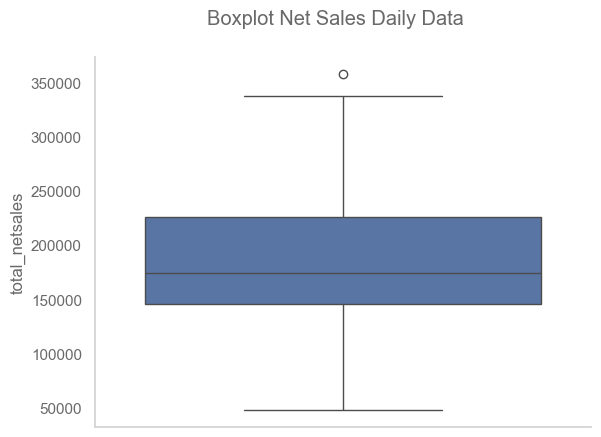

In [1059]:
sns.boxplot(aggregated_daily_sales_data['total_netsales'])
plt.suptitle('Boxplot Net Sales Daily Data')
plt.show()

Thus, no extreme outliers found in the aggregated daily data. Meaning we do not have to user normal distribution to clear out extreme outliers.

Before proceeding, we validate data using sum formula for data of 2024-01-01 and 2024-01-02

In [1060]:
checksum = sales_data[sales_data['salesdate'] == '2024-01-01']
checksum_test = sum(checksum['netsales'])
checksum_test

212632.05

In [1061]:
checksum2 = sales_data[sales_data['salesdate'] == '2024-01-02']
checksum_test2 = sum(checksum2['netsales'])
checksum_test2

108978.4

Thus, both values are the same as per aggregated code showing that the data is true.

In [1335]:
aggregated_daily_sales_data.tail()

,total_netsales
salesdate,
2024-12-27,115946.25
2024-12-28,161931.00
2024-12-29,146308.00
2024-12-30,82324.15
2024-12-31,139990.55


In [1063]:
aggregated_daily_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_netsales  366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


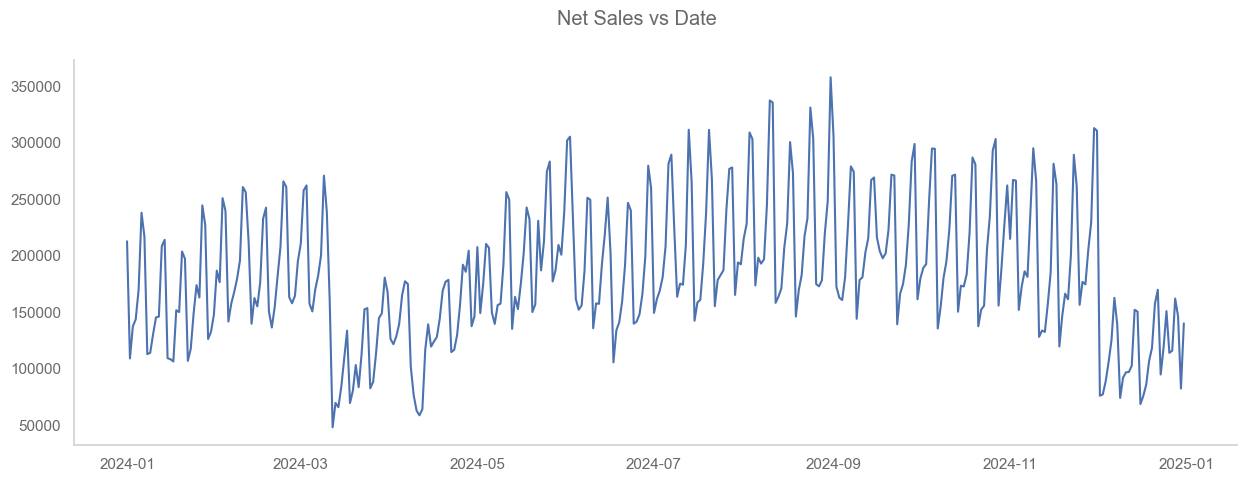

In [1105]:
plt.figure(figsize=(15, 5))
plt.plot(aggregated_daily_sales_data['total_netsales'])
plt.suptitle('Net Sales vs Date')
plt.show()

In [1065]:
missing_data(aggregated_daily_sales_data)

,Total,Percent,Types
total_netsales,0,0.00,float64


In [1066]:
aggregated_daily_sales_data_prophet = aggregated_daily_sales_data.reset_index()
aggregated_daily_sales_data_prophet.head()

,salesdate,total_netsales
0,2024-01-01,212632.05
1,2024-01-02,108978.40
2,2024-01-03,137190.40
3,2024-01-04,143665.95
4,2024-01-05,169797.80


In [1067]:
aggregated_daily_sales_data_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   salesdate       366 non-null    datetime64[ns]
 1   total_netsales  366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


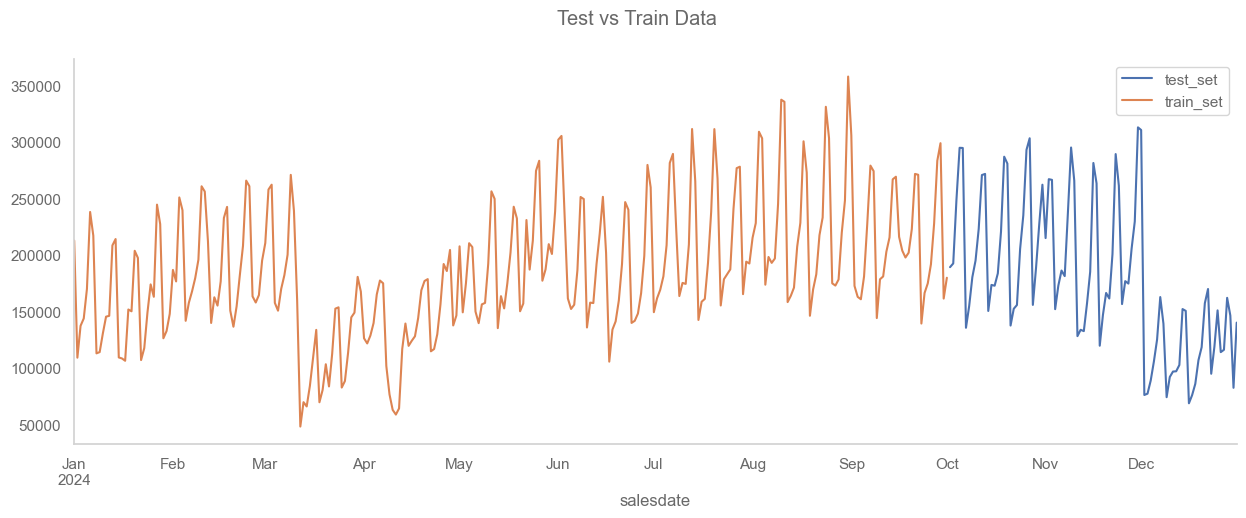

In [1068]:
# Train / Test Split

split_date = forecast_start_date
train_set =  aggregated_daily_sales_data.loc[aggregated_daily_sales_data.index <= split_date].copy()
test_set = aggregated_daily_sales_data.loc[aggregated_daily_sales_data.index > split_date].copy()


#Plot train and test so we can see where we have split
test_set \
    .rename(columns={'total_netsales' : 'test_set'}) \
    .join(train_set.rename(columns={'total_netsales' : 'train_set'}), how='outer') \
    .plot(figsize=(15,5))
plt.suptitle('Test vs Train Data')
plt.show()

In [1069]:
train_set.head()

,total_netsales
salesdate,
2024-01-01,212632.05
2024-01-02,108978.40
2024-01-03,137190.40
2024-01-04,143665.95
2024-01-05,169797.80


In [1070]:
test_set.head()

,total_netsales
salesdate,
2024-10-02,189083.00
2024-10-03,192370.85
2024-10-04,248192.60
2024-10-05,294698.75
2024-10-06,294536.35


In [1071]:
prediction_days = 90

In [1422]:
#adding holiday data

holiday = pd.DataFrame([])

malaysia_holidays = holidays.MY() #this is a dict
# the below is the same, but takes a string:
malaysia_holidays = holidays.country_holidays('MY') #this is a dict

for date_, name in sorted(holidays.MY(years=[2024,2025]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_,'holiday': "MY-holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_15716\2885166961.py:12: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead



,ds,holiday,lower_window,upper_window
0,2024-02-10,MY-holidays,-2,1
1,2024-02-11,MY-holidays,-2,1
2,2024-02-12,MY-holidays,-2,1
3,2024-04-10,MY-holidays,-2,1
4,2024-04-11,MY-holidays,-2,1


In [1531]:
forecast_start_dt = date(2024,10,1) #data set ends of (2024,12,31) which is 3 months
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_date)

2024-10-01


In [1532]:
## PROPHET MODEL

df_copy = aggregated_daily_sales_data_prophet.copy()
df_copy = df_copy.rename(columns={'salesdate':'ds', 'total_netsales': 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date)]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

21:50:03 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing


In [1533]:
m.train_holiday_names

In [1534]:
df_copy.head()

,ds,y
0,2024-01-01,212632.05
1,2024-01-02,108978.40
2,2024-01-03,137190.40
3,2024-01-04,143665.95
4,2024-01-05,169797.80


In [1535]:
predicted_df.head(10)

,ds,yhat
274,2024-10-01,194910.10
275,2024-10-02,206902.06
276,2024-10-03,219862.09
277,2024-10-04,243646.36
278,2024-10-05,301314.64
279,2024-10-06,293921.50
280,2024-10-07,200564.14
281,2024-10-08,197762.08
282,2024-10-09,209754.04
283,2024-10-10,222714.07


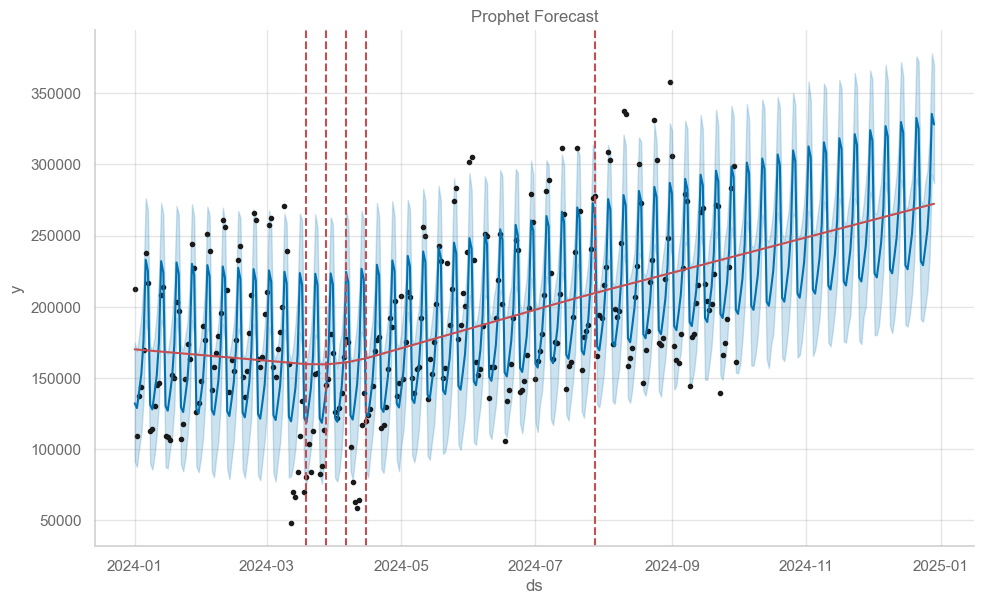

In [1536]:
fig = m.plot(fcst_prophet_train)
a = add_changepoints_to_plot(fig.gca(), m, fcst_prophet_train)
plt.title('Prophet Forecast')
plt.show()

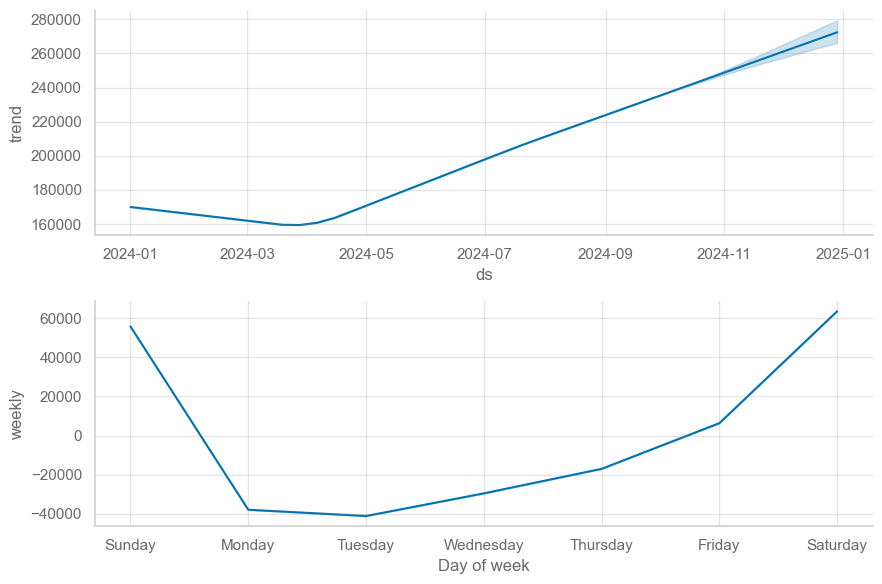

In [1537]:
fig1 = m.plot_components(fcst_prophet_train)
plt.show()

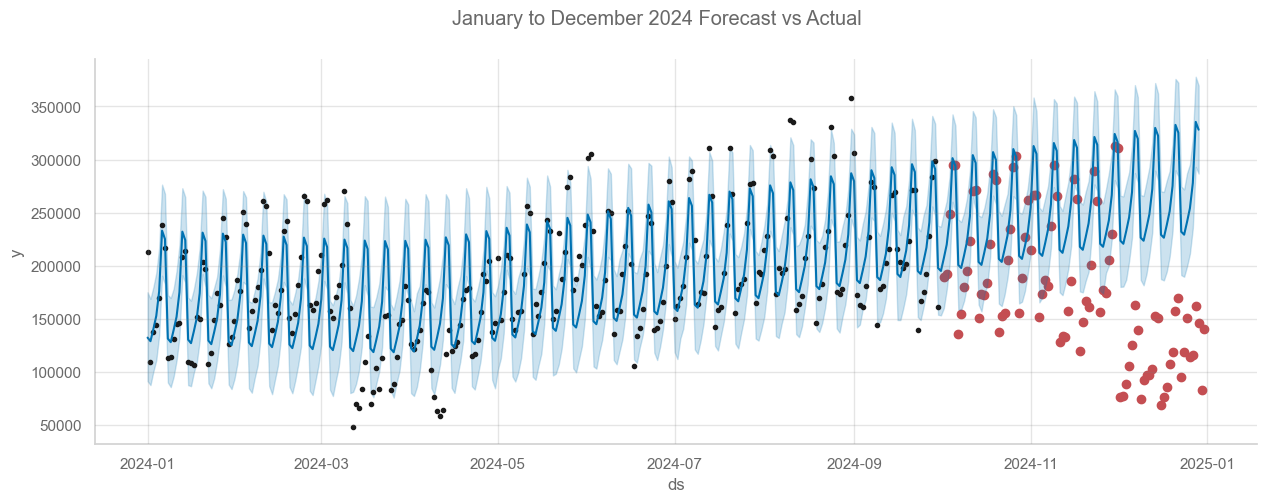

In [1538]:
#Plot the forecast with the actuals

f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test_set.index, test_set['total_netsales'],color='r')
fig = m.plot(fcst_prophet_train, ax=ax)
plot = plt.suptitle('January to December 2024 Forecast vs Actual')

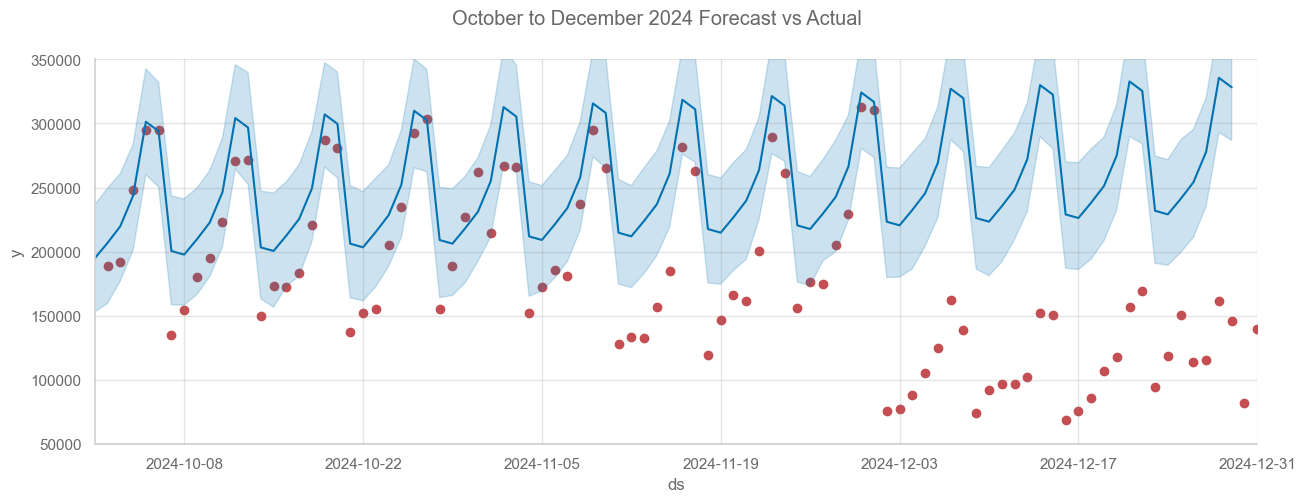

In [1539]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test_set.index, test_set['total_netsales'],color='r')
fig = m.plot(fcst_prophet_train, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2024-10-01'), 
              upper=pd.to_datetime('2024-12-31'))
ax.set_ylim(50000,350000)
plot = plt.suptitle('October to December 2024 Forecast vs Actual')

In [1540]:
aggregated_daily_sales_data_prophet.head()

,salesdate,total_netsales
0,2024-01-01,212632.05
1,2024-01-02,108978.40
2,2024-01-03,137190.40
3,2024-01-04,143665.95
4,2024-01-05,169797.80


In [1541]:
predicted_df.head()

,ds,yhat
274,2024-10-01,194910.10
275,2024-10-02,206902.06
276,2024-10-03,219862.09
277,2024-10-04,243646.36
278,2024-10-05,301314.64


In [1542]:
df_copy = aggregated_daily_sales_data_prophet.copy()
df_copy.columns = ['ds','ytrue']
predicted_df = predicted_df.merge(df_copy)

In [1543]:
predicted_df.head()

,ds,yhat,ytrue
0,2024-10-01,194910.10,179710.35
1,2024-10-02,206902.06,189083.00
2,2024-10-03,219862.09,192370.85
3,2024-10-04,243646.36,248192.60
4,2024-10-05,301314.64,294698.75


In [1544]:
predicted_df.tail()

,ds,yhat,ytrue
85,2024-12-25,241125.83,150840.15
86,2024-12-26,254085.86,113894.40
87,2024-12-27,277870.13,115946.25
88,2024-12-28,335538.41,161931.00
89,2024-12-29,328145.27,146308.00


In [1545]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

np.float64(59.63207006377217)

# Cross Validation with Prophet
Find the best parameters by testing over various periods of time with those parameteres (cross-validation).

In [1464]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [1465]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
print(seasonality_prior_scale_range)

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]


In [1467]:
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
print(holidays_prior_scale_range)

[0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]


In [1483]:
changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))
print(changepoint_range_range)

[np.float64(0.5), np.float64(0.6125), np.float64(0.725), np.float64(0.8374999999999999), np.float64(0.95)]


In [1485]:
df_copy = aggregated_daily_sales_data.copy().reset_index()
df_copy.columns = ['ds','y']

df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

param_grid = {
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,
        "holidays_prior_scale": holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        "changepoint_range": changepoint_range_range
}

    # Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

    # Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_copy)  # Fit model with given params
    df_cv = cross_validation(m, initial="270 days", period="30 days", horizon = "30 days") #took parallel out
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p)
    mapes.append(df_p["mape"].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mapes

21:20:40 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1] done processing
21:20:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:40 - cmdstanpy - INFO - Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
21:20:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.45it/s]
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  2.13it/s]
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6052005804.35 77794.64 64987.89  0.49   0.26   0.36      0.54


21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.51it/s]
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.85it/s]
21:20:45 - cmdstanpy - INFO - Chain [1] done processing
21:20:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6031689588.78 77663.95 64929.98  0.49   0.26   0.36      0.56


21:20:45 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.20it/s]
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.30it/s]
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6154125116.69 78448.23 66295.72  0.49   0.28   0.36      0.56


21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:49 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.52it/s]
21:20:49 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.80it/s]
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6038063545.65 77704.98 64777.08  0.49   0.26   0.35      0.54


21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.70it/s]
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.81it/s]
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6082855911.52 77992.67 65113.22  0.49   0.26   0.36      0.52


21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
21:20:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.85it/s]
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.21it/s]
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6052005804.35 77794.64 64987.89  0.49   0.26   0.36      0.53


21:20:54 - cmdstanpy - INFO - Chain [1] done processing
21:20:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:54 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.53it/s]
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.44it/s]
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6031689588.78 77663.95 64929.98  0.49   0.26   0.36      0.53


21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.90it/s]
21:20:58 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:20:58 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6154125116.69 78448.23 66295.72  0.49   0.28   0.36      0.56


21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.39it/s]
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.40it/s]
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6038063545.65 77704.98 64777.08  0.49   0.26   0.35      0.53


21:21:02 - cmdstanpy - INFO - Chain [1] done processing
21:21:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:02 - cmdstanpy - INFO - Chain [1] done processing
21:21:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.08it/s]
21:21:02 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]
21:21:04 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6082855911.52 77992.67 65113.22  0.49   0.26   0.36      0.53


21:21:04 - cmdstanpy - INFO - Chain [1] done processing
21:21:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:04 - cmdstanpy - INFO - Chain [1] done processing
21:21:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:04 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.93it/s]
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.34it/s]
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6052005804.35 77794.64 64987.89  0.49   0.26   0.36      0.54


21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.59it/s]
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.86it/s]
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6031689588.78 77663.95 64929.98  0.49   0.26   0.36      0.54


21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:10 - cmdstanpy - INFO - Chain [1] done processing
21:21:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:10 - cmdstanpy - INFO - Chain [1] done processing
21:21:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.43it/s]
21:21:10 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.20it/s]
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6154125116.69 78448.23 66295.72  0.49   0.28   0.36      0.58


21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.53it/s]
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.82it/s]
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6038063545.65 77704.98 64777.08  0.49   0.26   0.35      0.54


21:21:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.33it/s]
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.47it/s]
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:14 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]
21:21:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6082855911.52 77992.67 65113.22  0.49   0.26   0.36      0.53


21:21:15 - cmdstanpy - INFO - Chain [1] done processing
21:21:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:15 - cmdstanpy - INFO - Chain [1] start processing
21:21:15 - cmdstanpy - INFO - Chain [1] done processing
21:21:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:15 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.67it/s]
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.61it/s]
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6052005804.35 77794.64 64987.89  0.49   0.26   0.36      0.57


21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
21:21:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.82it/s]
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.52it/s]
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6031689588.78 77663.95 64929.98  0.49   0.26   0.36      0.54


21:21:19 - cmdstanpy - INFO - Chain [1] done processing
21:21:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:19 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.41it/s]
21:21:21 - cmdstanpy - INFO - Chain [1] done processing
21:21:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.00it/s]
21:21:21 - cmdstanpy - INFO - Chain [1] done processing
21:21:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6154125116.69 78448.23 66295.72  0.49   0.28   0.36      0.57


21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.65it/s]
21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.41it/s]
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6038063545.65 77704.98 64777.08  0.49   0.26   0.35      0.53


21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.00it/s]
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.25it/s]
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6082855911.52 77992.67 65113.22  0.49   0.26   0.36      0.53


21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.86it/s]
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.27it/s]
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6052005804.35 77794.64 64987.89  0.49   0.26   0.36      0.54


21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.76it/s]
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.34it/s]
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6031689588.78 77663.95 64929.98  0.49   0.26   0.36      0.53


21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.49it/s]
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.74it/s]
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6154125116.69 78448.23 66295.72  0.49   0.28   0.36      0.57


21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:35 - cmdstanpy - INFO - Chain [1] done processing
21:21:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.92it/s]
21:21:35 - cmdstanpy - INFO - Chain [1] done processing
21:21:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.96it/s]
21:21:35 - cmdstanpy - INFO - Chain [1] done processing
21:21:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6038063545.65 77704.98 64777.08  0.49   0.26   0.35      0.53


21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.46it/s]
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.47it/s]
21:21:37 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:37 - cmdstanpy - INFO - Chain [1] start processing
21:21:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]
21:21:37 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 6082855911.52 77992.67 65113.22  0.49   0.26   0.36      0.52


21:21:37 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:37 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.26it/s]
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.21it/s]
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5609455880.53 74896.30 60746.62  0.46   0.22   0.34      0.59


21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.94it/s]
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.05it/s]
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5043503154.69 71017.63 54100.17  0.42   0.14   0.30      0.63


21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:44 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:44 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.52it/s]
21:21:44 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.56it/s]
21:21:44 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5465723462.79 73930.53 58907.71  0.45   0.21   0.33      0.60


21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.74it/s]
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.69it/s]
21:21:47 - cmdstanpy - INFO - Chain [1] done processing
21:21:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552646540.49 74516.08 59901.00  0.45   0.21   0.34      0.60


21:21:48 - cmdstanpy - INFO - Chain [1] done processing
21:21:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:49 - cmdstanpy - INFO - Chain [1] done processing
21:21:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.83it/s]
21:21:49 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.83it/s]
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]
21:21:51 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506085673.00 74203.00 59440.32  0.45   0.21   0.34      0.59


21:21:51 - cmdstanpy - INFO - Chain [1] done processing
21:21:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:51 - cmdstanpy - INFO - Chain [1] start processing
21:21:51 - cmdstanpy - INFO - Chain [1] done processing
21:21:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:51 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.63it/s]
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.97it/s]
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5609455880.53 74896.30 60746.62  0.46   0.22   0.34      0.60


21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.52it/s]
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.85it/s]
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5043503154.69 71017.63 54100.17  0.42   0.14   0.30      0.64


21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:21:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:21:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:56 - cmdstanpy - INFO - Chain [1] done processing
21:21:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.12it/s]
21:21:56 - cmdstanpy - INFO - Chain [1] done processing
21:21:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.67it/s]
21:21:56 - cmdstanpy - INFO - Chain [1] done processing
21:21:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5465723462.79 73930.53 58907.71  0.45   0.21   0.33      0.60


21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
21:21:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:21:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:21:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.67it/s]
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.93it/s]
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552646540.49 74516.08 59901.00  0.45   0.21   0.34      0.59


21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
21:22:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
21:22:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]
21:22:02 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506085673.00 74203.00 59440.32  0.45   0.21   0.34      0.59


21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:02 - cmdstanpy - INFO - Chain [1] start processing
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.19it/s]
21:22:03 - cmdstanpy - INFO - Chain [1] done processing
21:22:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.81it/s]
21:22:03 - cmdstanpy - INFO - Chain [1] done processing
21:22:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5609455880.53 74896.30 60746.62  0.46   0.22   0.34      0.60


21:22:04 - cmdstanpy - INFO - Chain [1] start processing
21:22:04 - cmdstanpy - INFO - Chain [1] done processing
21:22:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:04 - cmdstanpy - INFO - Chain [1] done processing
21:22:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.90it/s]
21:22:05 - cmdstanpy - INFO - Chain [1] done processing
21:22:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.99it/s]
21:22:05 - cmdstanpy - INFO - Chain [1] done processing
21:22:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:05 - cmdstanpy - INFO - Chain [1] start processing
21:22:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5043503154.69 71017.63 54100.17  0.42   0.14   0.30      0.64


21:22:06 - cmdstanpy - INFO - Chain [1] done processing
21:22:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:06 - cmdstanpy - INFO - Chain [1] start processing
21:22:06 - cmdstanpy - INFO - Chain [1] done processing
21:22:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:06 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.38it/s]
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.03it/s]
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5465723462.79 73930.53 58907.71  0.45   0.21   0.33      0.60


21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:08 - cmdstanpy - INFO - Chain [1] done processing
21:22:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:08 - cmdstanpy - INFO - Chain [1] done processing
21:22:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.91it/s]
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
21:22:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.82it/s]
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
21:22:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:09 - cmdstanpy - INFO - Chain [1] start processing
21:22:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552646540.49 74516.08 59901.00  0.45   0.21   0.34      0.60


21:22:10 - cmdstanpy - INFO - Chain [1] done processing
21:22:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:10 - cmdstanpy - INFO - Chain [1] done processing
21:22:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.85it/s]
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.91it/s]
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:11 - cmdstanpy - INFO - Chain [1] start processing
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]
21:22:12 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506085673.00 74203.00 59440.32  0.45   0.21   0.34      0.58


21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.04it/s]
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5609455880.53 74896.30 60746.62  0.46   0.22   0.34      0.59


21:22:15 - cmdstanpy - INFO - Chain [1] done processing
21:22:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:15 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.14it/s]
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.29it/s]
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]
21:22:17 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5043503154.69 71017.63 54100.17  0.42   0.14   0.30      0.64


21:22:17 - cmdstanpy - INFO - Chain [1] done processing
21:22:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:17 - cmdstanpy - INFO - Chain [1] start processing
21:22:17 - cmdstanpy - INFO - Chain [1] done processing
21:22:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:17 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.61it/s]
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.90it/s]
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5465723462.79 73930.53 58907.71  0.45   0.21   0.33      0.59


21:22:19 - cmdstanpy - INFO - Chain [1] done processing
21:22:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:19 - cmdstanpy - INFO - Chain [1] start processing
21:22:19 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.79it/s]
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.90it/s]
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552646540.49 74516.08 59901.00  0.45   0.21   0.34      0.59


21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.58it/s]
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.25it/s]
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]
21:22:23 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506085673.00 74203.00 59440.32  0.45   0.21   0.34      0.58


21:22:23 - cmdstanpy - INFO - Chain [1] done processing
21:22:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.20it/s]
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]
21:22:25 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5609455880.53 74896.30 60746.62  0.46   0.22   0.34      0.60


21:22:25 - cmdstanpy - INFO - Chain [1] done processing
21:22:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:25 - cmdstanpy - INFO - Chain [1] done processing
21:22:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.09it/s]
21:22:26 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.32it/s]
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]
21:22:28 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5043503154.69 71017.63 54100.17  0.42   0.14   0.30      0.64


21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.95it/s]
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.86it/s]
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5465723462.79 73930.53 58907.71  0.45   0.21   0.33      0.60


21:22:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:30 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.60it/s]
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.02it/s]
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:31 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552646540.49 74516.08 59901.00  0.45   0.21   0.34      0.57


21:22:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:32 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.78it/s]
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.34it/s]
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506085673.00 74203.00 59440.32  0.45   0.21   0.34      0.59


21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.84it/s]
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.89it/s]
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5556153616.02 74539.61 60521.32  0.45   0.22   0.34      0.60


21:22:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.05it/s]
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:38 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034236812.35 70952.36 53900.05  0.42   0.15   0.30      0.64


21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.46it/s]
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.93it/s]
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5460554617.19 73895.57 58778.10  0.45   0.21   0.33      0.61


21:22:41 - cmdstanpy - INFO - Chain [1] done processing
21:22:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:41 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:02,  1.06s/it]
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.62it/s]
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5533969436.97 74390.65 59418.30  0.45   0.21   0.34      0.58


21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.37it/s]
21:22:45 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.50it/s]
21:22:45 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:45 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506961569.68 74208.90 59318.51  0.45   0.21   0.34      0.60


21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
21:22:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.66it/s]
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5556153616.02 74539.61 60521.32  0.45   0.22   0.34      0.61


21:22:48 - cmdstanpy - INFO - Chain [1] done processing
21:22:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:48 - cmdstanpy - INFO - Chain [1] start processing
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.29it/s]
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.24it/s]
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034236812.35 70952.36 53900.05  0.42   0.15   0.30      0.64


21:22:50 - cmdstanpy - INFO - Chain [1] done processing
21:22:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:50 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.17it/s]
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.06it/s]
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5460554617.19 73895.57 58778.10  0.45   0.21   0.33      0.60


21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.56it/s]
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.78it/s]
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5533969436.97 74390.65 59418.30  0.45   0.21   0.34      0.58


21:22:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.01it/s]
21:22:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.24it/s]
21:22:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:56 - cmdstanpy - INFO - Chain [1] start processing
21:22:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]
21:22:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506961569.68 74208.90 59318.51  0.45   0.21   0.34      0.59


21:22:57 - cmdstanpy - INFO - Chain [1] done processing
21:22:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:57 - cmdstanpy - INFO - Chain [1] start processing
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.47it/s]
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:22:58 - cmdstanpy - INFO - Chain [1] done processing
21:22:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5556153616.02 74539.61 60521.32  0.45   0.22   0.34      0.59


21:22:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.97it/s]
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.79it/s]
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:01 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034236812.35 70952.36 53900.05  0.42   0.15   0.30      0.64


21:23:01 - cmdstanpy - INFO - Chain [1] done processing
21:23:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:01 - cmdstanpy - INFO - Chain [1] start processing
21:23:02 - cmdstanpy - INFO - Chain [1] done processing
21:23:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:02 - cmdstanpy - INFO - Chain [1] done processing
21:23:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.16it/s]
21:23:02 - cmdstanpy - INFO - Chain [1] done processing
21:23:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.75it/s]
21:23:02 - cmdstanpy - INFO - Chain [1] done processing
21:23:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5460554617.19 73895.57 58778.10  0.45   0.21   0.33      0.60


21:23:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:03 - cmdstanpy - INFO - Chain [1] start processing
21:23:04 - cmdstanpy - INFO - Chain [1] done processing
21:23:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:04 - cmdstanpy - INFO - Chain [1] done processing
21:23:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.06it/s]
21:23:05 - cmdstanpy - INFO - Chain [1] done processing
21:23:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.35it/s]
21:23:05 - cmdstanpy - INFO - Chain [1] done processing
21:23:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:05 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5533969436.97 74390.65 59418.30  0.45   0.21   0.34      0.58


21:23:06 - cmdstanpy - INFO - Chain [1] start processing
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.21it/s]
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506961569.68 74208.90 59318.51  0.45   0.21   0.34      0.58


21:23:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.24it/s]
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.65it/s]
21:23:09 - cmdstanpy - INFO - Chain [1] done processing
21:23:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:09 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5556153616.02 74539.61 60521.32  0.45   0.22   0.34      0.59


21:23:09 - cmdstanpy - INFO - Chain [1] start processing
21:23:09 - cmdstanpy - INFO - Chain [1] done processing
21:23:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:09 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.04it/s]
21:23:11 - cmdstanpy - INFO - Chain [1] done processing
21:23:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.92it/s]
21:23:11 - cmdstanpy - INFO - Chain [1] done processing
21:23:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034236812.35 70952.36 53900.05  0.42   0.15   0.30      0.64


21:23:12 - cmdstanpy - INFO - Chain [1] start processing
21:23:12 - cmdstanpy - INFO - Chain [1] done processing
21:23:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:12 - cmdstanpy - INFO - Chain [1] start processing
21:23:13 - cmdstanpy - INFO - Chain [1] done processing
21:23:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:13 - cmdstanpy - INFO - Chain [1] done processing
21:23:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.95it/s]
21:23:13 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.82it/s]
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5460554617.19 73895.57 58778.10  0.45   0.21   0.33      0.61


21:23:15 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:16 - cmdstanpy - INFO - Chain [1] done processing
21:23:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:18 - cmdstanpy - INFO - Chain [1] done processing
21:23:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:03,  1.78s/it]
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.20s/it]
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5533969436.97 74390.65 59418.30  0.45   0.21   0.34      0.57


21:23:20 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:21 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.69it/s]
21:23:21 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.46it/s]
21:23:21 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:21 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506961569.68 74208.90 59318.51  0.45   0.21   0.34      0.60


21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] done processing
21:23:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:23 - cmdstanpy - INFO - Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] done processing
21:23:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:23 - cmdstanpy - INFO - Chain [1] done processing
21:23:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.38it/s]
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5556153616.02 74539.61 60521.32  0.45   0.22   0.34      0.60


21:23:25 - cmdstanpy - INFO - Chain [1] done processing
21:23:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:25 - cmdstanpy - INFO - Chain [1] start processing
21:23:25 - cmdstanpy - INFO - Chain [1] done processing
21:23:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:25 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.51it/s]
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.21it/s]
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034236812.35 70952.36 53900.05  0.42   0.15   0.30      0.64


21:23:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.52it/s]
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.11it/s]
21:23:30 - cmdstanpy - INFO - Chain [1] done processing
21:23:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:30 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5460554617.19 73895.57 58778.10  0.45   0.21   0.33      0.60


21:23:31 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing
21:23:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:31 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.44it/s]
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.77it/s]
21:23:33 - cmdstanpy - INFO - Chain [1] done processing
21:23:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5533969436.97 74390.65 59418.30  0.45   0.21   0.34      0.58


21:23:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.79it/s]
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.23it/s]
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5506961569.68 74208.90 59318.51  0.45   0.21   0.34      0.61


21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
21:23:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:36 - cmdstanpy - INFO - Chain [1] done processing
21:23:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:36 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.11it/s]
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.02it/s]
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552189171.78 74513.01 60395.53  0.45   0.22   0.34      0.58


21:23:38 - cmdstanpy - INFO - Chain [1] done processing
21:23:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:38 - cmdstanpy - INFO - Chain [1] start processing
21:23:38 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.10it/s]
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034160099.13 70951.82 53928.76  0.42   0.15   0.30      0.62


21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:42 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.73it/s]
21:23:42 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.62it/s]
21:23:42 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5461492019.33 73901.91 58787.89  0.45   0.21   0.33      0.60


21:23:45 - cmdstanpy - INFO - Chain [1] done processing
21:23:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:45 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:03,  1.87s/it]
21:23:49 - cmdstanpy - INFO - Chain [1] done processing
21:23:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.09s/it]
21:23:49 - cmdstanpy - INFO - Chain [1] done processing
21:23:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4971002136.50 70505.33 52499.09  0.42   0.14   0.30      0.64


21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.61it/s]
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.68it/s]
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5513035004.17 74249.81 59486.21  0.45   0.21   0.34      0.60


21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.11it/s]
21:23:54 - cmdstanpy - INFO - Chain [1] done processing
21:23:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.17it/s]
21:23:54 - cmdstanpy - INFO - Chain [1] done processing
21:23:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552189171.78 74513.01 60395.53  0.45   0.22   0.34      0.59


21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
21:23:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
21:23:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.37it/s]
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
21:23:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.62it/s]
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
21:23:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034160099.13 70951.82 53928.76  0.42   0.15   0.30      0.64


21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:58 - cmdstanpy - INFO - Chain [1] done processing
21:23:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:23:58 - cmdstanpy - INFO - Chain [1] done processing
21:23:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.13it/s]
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.35it/s]
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5461492019.33 73901.91 58787.89  0.45   0.21   0.33      0.60


21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:02<00:05,  2.65s/it]
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.26s/it]
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4971002136.50 70505.33 52499.09  0.42   0.14   0.30      0.64


21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.56it/s]
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.14it/s]
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5513035004.17 74249.81 59486.21  0.45   0.21   0.34      0.60


21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:07 - cmdstanpy - INFO - Chain [1] done processing
21:24:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:10 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.01it/s]
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.51s/it]
21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552189171.78 74513.01 60395.53  0.45   0.22   0.34      0.59


21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:15 - cmdstanpy - INFO - Chain [1] done processing
21:24:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.41it/s]
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.10it/s]
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034160099.13 70951.82 53928.76  0.42   0.15   0.30      0.63


21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:18 - cmdstanpy - INFO - Chain [1] done processing
21:24:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
21:24:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
21:24:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.31it/s]
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.23it/s]
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5461492019.33 73901.91 58787.89  0.45   0.21   0.33      0.61


21:24:21 - cmdstanpy - INFO - Chain [1] done processing
21:24:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:21 - cmdstanpy - INFO - Chain [1] start processing
21:24:22 - cmdstanpy - INFO - Chain [1] done processing
21:24:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:22 - cmdstanpy - INFO - Chain [1] done processing
21:24:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:24:22 - cmdstanpy - INFO - Chain [1] done processing
21:24:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.36it/s]
21:24:23 - cmdstanpy - INFO - Chain [1] done processing
21:24:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4971002136.50 70505.33 52499.09  0.42   0.14   0.30      0.64


21:24:23 - cmdstanpy - INFO - Chain [1] start processing
21:24:24 - cmdstanpy - INFO - Chain [1] done processing
21:24:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:24 - cmdstanpy - INFO - Chain [1] done processing
21:24:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.40it/s]
21:24:24 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.41it/s]
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5513035004.17 74249.81 59486.21  0.45   0.21   0.34      0.58


21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.76it/s]
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.67it/s]
21:24:28 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552189171.78 74513.01 60395.53  0.45   0.22   0.34      0.60


21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:30 - cmdstanpy - INFO - Chain [1] done processing
21:24:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.54it/s]
21:24:30 - cmdstanpy - INFO - Chain [1] done processing
21:24:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.49it/s]
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034160099.13 70951.82 53928.76  0.42   0.15   0.30      0.63


21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.90it/s]
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
21:24:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.09it/s]
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
21:24:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5461492019.33 73901.91 58787.89  0.45   0.21   0.33      0.61


21:24:34 - cmdstanpy - INFO - Chain [1] done processing
21:24:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
21:24:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
21:24:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.54it/s]
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.52it/s]
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4971002136.50 70505.33 52499.09  0.42   0.14   0.30      0.64


21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.14it/s]
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.11it/s]
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5513035004.17 74249.81 59486.21  0.45   0.21   0.34      0.58


21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:44 - cmdstanpy - INFO - Chain [1] done processing
21:24:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:03<00:06,  3.25s/it]
21:24:44 - cmdstanpy - INFO - Chain [1] done processing
21:24:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:03<00:01,  1.55s/it]
21:24:44 - cmdstanpy - INFO - Chain [1] done processing
21:24:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5552189171.78 74513.01 60395.53  0.45   0.22   0.34      0.59


21:24:45 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.96it/s]
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5034160099.13 70951.82 53928.76  0.42   0.15   0.30      0.64


21:24:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.24it/s]
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.61it/s]
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:48 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5461492019.33 73901.91 58787.89  0.45   0.21   0.33      0.59


Optimization terminated abnormally. Falling back to Newton.
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.44it/s]
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
21:24:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:51 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████████████████████

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4971002136.50 70505.33 52499.09  0.42   0.14   0.30      0.63


21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.69it/s]
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.32it/s]
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]
21:24:54 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5513035004.17 74249.81 59486.21  0.45   0.21   0.34      0.59


21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.41it/s]
21:24:55 - cmdstanpy - INFO - Chain [1] done processing
21:24:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.26it/s]
21:24:55 - cmdstanpy - INFO - Chain [1] done processing
21:24:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5564331563.20 74594.45 60611.72  0.45   0.22   0.34      0.59


21:24:55 - cmdstanpy - INFO - Chain [1] done processing
21:24:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.61it/s]
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.65it/s]
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5080086867.26 71274.73 54586.97  0.43   0.15   0.31      0.63


21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.00it/s]
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.03it/s]
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5457133585.86 73872.41 58737.00  0.45   0.21   0.33      0.60


21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:02 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:25:02 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.21it/s]
21:25:02 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5497538030.33 74145.38 58950.55  0.45   0.21   0.33      0.59


21:25:03 - cmdstanpy - INFO - Chain [1] done processing
21:25:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:03 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.34it/s]
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.22it/s]
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]
21:25:05 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5514594428.09 74260.32 59506.29  0.45   0.21   0.34      0.58


21:25:05 - cmdstanpy - INFO - Chain [1] done processing
21:25:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:05 - cmdstanpy - INFO - Chain [1] start processing
21:25:05 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.19it/s]
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.98it/s]
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5564331563.20 74594.45 60611.72  0.45   0.22   0.34      0.59


21:25:07 - cmdstanpy - INFO - Chain [1] done processing
21:25:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:07 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.05it/s]
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.54it/s]
21:25:09 - cmdstanpy - INFO - Chain [1] done processing
21:25:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5080086867.26 71274.73 54586.97  0.43   0.15   0.31      0.63


21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.49it/s]
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.69it/s]
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not perm

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5457133585.86 73872.41 58737.00  0.45   0.21   0.33      0.61


21:25:12 - cmdstanpy - INFO - Chain [1] done processing
21:25:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:12 - cmdstanpy - INFO - Chain [1] start processing
21:25:13 - cmdstanpy - INFO - Chain [1] done processing
21:25:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:13 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.52it/s]
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  2.00it/s]
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5497538030.33 74145.38 58950.55  0.45   0.21   0.33      0.58


21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.08it/s]
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
21:25:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.83it/s]
21:25:17 - cmdstanpy - INFO - Chain [1] done processing
21:25:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:17 - cmdstanpy - INFO - Chain [1] start processing
21:25:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]
21:25:18 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5514594428.09 74260.32 59506.29  0.45   0.21   0.34      0.58


21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:19 - cmdstanpy - INFO - Chain [1] done processing
21:25:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:19 - cmdstanpy - INFO - Chain [1] done processing
21:25:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.72it/s]
21:25:19 - cmdstanpy - INFO - Chain [1] done processing
21:25:20 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.91it/s]
21:25:20 - cmdstanpy - INFO - Chain [1] done processing
21:25:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5564331563.20 74594.45 60611.72  0.45   0.22   0.34      0.60


21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:21 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.09it/s]
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.55it/s]
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5080086867.26 71274.73 54586.97  0.43   0.15   0.31      0.64


21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:24 - cmdstanpy - INFO - Chain [1] done processing
21:25:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:24 - cmdstanpy - INFO - Chain [1] done processing
21:25:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.76it/s]
21:25:24 - cmdstanpy - INFO - Chain [1] done processing
21:25:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.00it/s]
21:25:25 - cmdstanpy - INFO - Chain [1] done processing
21:25:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5457133585.86 73872.41 58737.00  0.45   0.21   0.33      0.61


21:25:25 - cmdstanpy - INFO - Chain [1] done processing
21:25:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:25 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.47it/s]
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.90it/s]
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5497538030.33 74145.38 58950.55  0.45   0.21   0.33      0.59


21:25:27 - cmdstanpy - INFO - Chain [1] done processing
21:25:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:28 - cmdstanpy - INFO - Chain [1] done processing
21:25:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.32it/s]
21:25:28 - cmdstanpy - INFO - Chain [1] done processing
21:25:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.51it/s]
21:25:28 - cmdstanpy - INFO - Chain [1] done processing
21:25:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:28 - cmdstanpy - INFO - Chain [1] start processing
21:25:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]
21:25:29 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5514594428.09 74260.32 59506.29  0.45   0.21   0.34      0.59


21:25:29 - cmdstanpy - INFO - Chain [1] done processing
21:25:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:29 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.24it/s]
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5564331563.20 74594.45 60611.72  0.45   0.22   0.34      0.59


21:25:31 - cmdstanpy - INFO - Chain [1] done processing
21:25:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.69it/s]
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.79it/s]
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5080086867.26 71274.73 54586.97  0.43   0.15   0.31      0.64


21:25:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.78it/s]
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.91it/s]
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:34 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5457133585.86 73872.41 58737.00  0.45   0.21   0.33      0.59


21:25:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.35it/s]
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.28it/s]
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:36 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5497538030.33 74145.38 58950.55  0.45   0.21   0.33      0.60


21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.95it/s]
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.05it/s]
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]
21:25:39 - cmdstanpy - INFO

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5514594428.09 74260.32 59506.29  0.45   0.21   0.34      0.59


21:25:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:25:40 - cmdstanpy - INFO - Chain [1] done processing
21:25:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.07it/s]
21:25:40 - cmdstanpy - INFO - Chain [1] done processing
21:25:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:40 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5564331563.20 74594.45 60611.72  0.45   0.22   0.34      0.61


21:25:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.01it/s]
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.63it/s]
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
21:25:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:42 - cmdstanpy - INFO - Chain [1] start p

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5080086867.26 71274.73 54586.97  0.43   0.15   0.31      0.63


21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.44it/s]
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.19it/s]
21:25:44 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5457133585.86 73872.41 58737.00  0.45   0.21   0.33      0.60


21:25:44 - cmdstanpy - INFO - Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.71it/s]
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████|

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5497538030.33 74145.38 58950.55  0.45   0.21   0.33      0.60


21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.45it/s]
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.81it/s]
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 5514594428.09 74260.32 59506.29  0.45   0.21   0.34      0.61


21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.19it/s]
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.65it/s]
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]
21:25:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4715111953.11 68666.67 56609.05  0.46   0.31   0.33      0.44


21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.93it/s]
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.30it/s]
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]
21:25:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3965609683.25 62973.09 52340.39  0.42   0.27   0.31      0.46


21:25:51 - cmdstanpy - INFO - Chain [1] done processing
21:25:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:51 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.49it/s]
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.17it/s]
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3615883481.30 60132.22 50090.28  0.40   0.22   0.30      0.51


21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:53 - cmdstanpy - INFO - Chain [1] done processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:25:53 - cmdstanpy - INFO - Chain [1] done processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.57it/s]
21:25:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]
21:25:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3611143556.66 60092.79 49974.12  0.40   0.23   0.30      0.49


21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.95it/s]
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.90it/s]
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]
21:25:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3617627786.68 60146.72 50067.42  0.40   0.22   0.30      0.51


21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.45it/s]
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.72it/s]
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4715111953.11 68666.67 56609.05  0.46   0.31   0.33      0.44


21:25:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.07it/s]
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.09it/s]
21:25:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]
21:25:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3965609683.25 62973.09 52340.39  0.42   0.27   0.31      0.48


21:25:57 - cmdstanpy - INFO - Chain [1] done processing
21:25:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:57 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.72it/s]
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.96it/s]
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]
21:25:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3615883481.30 60132.22 50090.28  0.40   0.22   0.30      0.51


21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.84it/s]
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.47it/s]
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]
21:25:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3611143556.66 60092.79 49974.12  0.40   0.23   0.30      0.52


21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.18it/s]
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.07it/s]
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.92it/s]
21:26:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3617627786.68 60146.72 50067.42  0.40   0.22   0.30      0.50


21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.49it/s]
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.53it/s]
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4715111953.11 68666.67 56609.05  0.46   0.31   0.33      0.46


21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.57it/s]
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]
21:26:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3965609683.25 62973.09 52340.39  0.42   0.27   0.31      0.48


21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.09it/s]
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]
21:26:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3615883481.30 60132.22 50090.28  0.40   0.22   0.30      0.50


21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.31it/s]
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.08it/s]
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3611143556.66 60092.79 49974.12  0.40   0.23   0.30      0.50


21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.92it/s]
21:26:06 - cmdstanpy - INFO - Chain [1] done processing
21:26:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.60it/s]
21:26:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.28it/s]
21:26:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3617627786.68 60146.72 50067.42  0.40   0.22   0.30      0.52


21:26:06 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.62it/s]
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.54it/s]
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]
21:26:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4715111953.11 68666.67 56609.05  0.46   0.31   0.33      0.46


21:26:08 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:08 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.81it/s]
21:26:08 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.95it/s]
21:26:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3965609683.25 62973.09 52340.39  0.42   0.27   0.31      0.48


21:26:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.44it/s]
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.57it/s]
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]
21:26:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3615883481.30 60132.22 50090.28  0.40   0.22   0.30      0.51


21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.57it/s]
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.68it/s]
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.76it/s]
21:26:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3611143556.66 60092.79 49974.12  0.40   0.23   0.30      0.50


21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.70it/s]
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.26it/s]
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]
21:26:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3617627786.68 60146.72 50067.42  0.40   0.22   0.30      0.50


21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.52it/s]
21:26:13 - cmdstanpy - INFO - Chain [1] done processing
21:26:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.18it/s]
21:26:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.28it/s]
21:26:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4715111953.11 68666.67 56609.05  0.46   0.31   0.33      0.46


21:26:13 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.49it/s]
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.77it/s]
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:26:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3965609683.25 62973.09 52340.39  0.42   0.27   0.31      0.49


21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.95it/s]
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.17it/s]
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.17it/s]
21:26:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3615883481.30 60132.22 50090.28  0.40   0.22   0.30      0.50


21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.96it/s]
21:26:19 - cmdstanpy - INFO - Chain [1] done processing
21:26:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.80it/s]
21:26:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3611143556.66 60092.79 49974.12  0.40   0.23   0.30      0.50


21:26:20 - cmdstanpy - INFO - Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] done processing
21:26:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.36it/s]
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.91it/s]
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]
21:26:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3617627786.68 60146.72 50067.42  0.40   0.22   0.30      0.51


21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.84it/s]
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.49it/s]
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]
21:26:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4165937532.57 64544.07 51020.51  0.41   0.23   0.30      0.52


21:26:23 - cmdstanpy - INFO - Chain [1] done processing
21:26:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:23 - cmdstanpy - INFO - Chain [1] done processing
21:26:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.00it/s]
21:26:23 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.78it/s]
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]
21:26:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533631541.26 59444.36 46363.64  0.37   0.18   0.28      0.53


21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.17it/s]
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.61it/s]
21:26:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.75it/s]
21:26:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3137045652.68 56009.34 42820.26  0.35   0.15   0.26      0.56


21:26:25 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:25 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.01it/s]
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.02it/s]
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]
21:26:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3073752329.04 55441.43 42103.77  0.34   0.16   0.26      0.58


21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
21:26:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.61it/s]
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
21:26:27 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.21it/s]
21:26:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3109419383.44 55762.17 42248.46  0.34   0.15   0.26      0.57


21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.28it/s]
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.61it/s]
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4165937532.57 64544.07 51020.51  0.41   0.23   0.30      0.49


21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
21:26:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
21:26:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.09it/s]
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.00it/s]
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533631541.26 59444.36 46363.64  0.37   0.18   0.28      0.53


21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:31 - cmdstanpy - INFO - Chain [1] done processing
21:26:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:31 - cmdstanpy - INFO - Chain [1] done processing
21:26:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.32it/s]
21:26:31 - cmdstanpy - INFO - Chain [1] done processing
21:26:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.00it/s]
21:26:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]
21:26:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3137045652.68 56009.34 42820.26  0.35   0.15   0.26      0.56


21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.50it/s]
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.70it/s]
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]
21:26:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3073752329.04 55441.43 42103.77  0.34   0.16   0.26      0.57


21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:02<00:04,  2.15s/it]
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.03s/it]
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]
21:26:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3109419383.44 55762.17 42248.46  0.34   0.15   0.26      0.57


21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.54it/s]
21:26:37 - cmdstanpy - INFO - Chain [1] done processing
21:26:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.89it/s]
21:26:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]
21:26:37 - cmdstanpy - INFO - Chain [1] start processing
21:26:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4165937532.57 64544.07 51020.51  0.41   0.23   0.30      0.52


21:26:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:37 - cmdstanpy - INFO - Chain [1] done processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.87it/s]
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.86it/s]
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]
21:26:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533631541.26 59444.36 46363.64  0.37   0.18   0.28      0.53


21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.62it/s]
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.82it/s]
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]
21:26:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3137045652.68 56009.34 42820.26  0.35   0.15   0.26      0.54


21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:40 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.37it/s]
21:26:40 - cmdstanpy - INFO - Chain [1] done processing
21:26:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.97it/s]
21:26:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.87it/s]
21:26:40 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3073752329.04 55441.43 42103.77  0.34   0.16   0.26      0.58


21:26:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.87it/s]
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.63it/s]
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]
21:26:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3109419383.44 55762.17 42248.46  0.34   0.15   0.26      0.57


21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.19it/s]
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.75it/s]
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]
21:26:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4165937532.57 64544.07 51020.51  0.41   0.23   0.30      0.51


21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:44 - cmdstanpy - INFO - Chain [1] done processing
21:26:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.48it/s]
21:26:44 - cmdstanpy - INFO - Chain [1] done processing
21:26:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.98it/s]
21:26:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533631541.26 59444.36 46363.64  0.37   0.18   0.28      0.54


21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.87it/s]
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.56it/s]
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3137045652.68 56009.34 42820.26  0.35   0.15   0.26      0.56


21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.18it/s]
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.29it/s]
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]
21:26:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3073752329.04 55441.43 42103.77  0.34   0.16   0.26      0.57


21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.43it/s]
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.46it/s]
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]
21:26:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3109419383.44 55762.17 42248.46  0.34   0.15   0.26      0.58


21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.39it/s]
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.58it/s]
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]
21:26:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4165937532.57 64544.07 51020.51  0.41   0.23   0.30      0.51


21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.91it/s]
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.89it/s]
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]
21:26:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533631541.26 59444.36 46363.64  0.37   0.18   0.28      0.53


21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.21it/s]
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.99it/s]
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]
21:26:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3137045652.68 56009.34 42820.26  0.35   0.15   0.26      0.54


21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.80it/s]
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.01it/s]
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:26:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3073752329.04 55441.43 42103.77  0.34   0.16   0.26      0.57


21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.08it/s]
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.93it/s]
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]
21:26:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3109419383.44 55762.17 42248.46  0.34   0.15   0.26      0.56


21:26:55 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.93it/s]
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.70it/s]
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]
21:26:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4184838545.75 64690.33 51054.10  0.41   0.23   0.30      0.52


21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.67it/s]
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.34it/s]
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]
21:26:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3524814428.57 59370.15 46500.42  0.38   0.18   0.28      0.53


21:26:58 - cmdstanpy - INFO - Chain [1] done processing
21:26:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:03,  1.70s/it]
21:27:00 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.37s/it]
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169361045.31 56297.08 43171.28  0.35   0.16   0.26      0.54


21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:02,  1.27s/it]
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.10it/s]
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]
21:27:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3095129496.76 55633.89 42111.08  0.34   0.16   0.26      0.58


21:27:05 - cmdstanpy - INFO - Chain [1] done processing
21:27:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:05 - cmdstanpy - INFO - Chain [1] done processing
21:27:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.40it/s]
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.98it/s]
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]
21:27:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3181819732.14 56407.62 42725.59  0.35   0.15   0.26      0.56


21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:07 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.00it/s]
21:27:07 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.76it/s]
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]
21:27:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4184838545.75 64690.33 51054.10  0.41   0.23   0.30      0.51


21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.38it/s]
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.78it/s]
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]
21:27:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3524814428.57 59370.15 46500.42  0.38   0.18   0.28      0.53


21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:11 - cmdstanpy - INFO - Chain [1] done processing
21:27:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.70it/s]
21:27:11 - cmdstanpy - INFO - Chain [1] done processing
21:27:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.19it/s]
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]
21:27:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169361045.31 56297.08 43171.28  0.35   0.16   0.26      0.54


21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.87it/s]
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.20it/s]
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]
21:27:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3095129496.76 55633.89 42111.08  0.34   0.16   0.26      0.58


21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:15 - cmdstanpy - INFO - Chain [1] done processing
21:27:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.11it/s]
21:27:15 - cmdstanpy - INFO - Chain [1] done processing
21:27:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.29it/s]
21:27:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]
21:27:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3181819732.14 56407.62 42725.59  0.35   0.15   0.26      0.58


21:27:15 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.42it/s]
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.31it/s]
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]
21:27:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4184838545.75 64690.33 51054.10  0.41   0.23   0.30      0.52


21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.25it/s]
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]
21:27:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3524814428.57 59370.15 46500.42  0.38   0.18   0.28      0.53


21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.96it/s]
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.22it/s]
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.03it/s]
21:27:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169361045.31 56297.08 43171.28  0.35   0.16   0.26      0.54


21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.05it/s]
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.32it/s]
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]
21:27:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3095129496.76 55633.89 42111.08  0.34   0.16   0.26      0.58


21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.75it/s]
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.08it/s]
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.95it/s]
21:27:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3181819732.14 56407.62 42725.59  0.35   0.15   0.26      0.56


21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.03it/s]
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.45it/s]
21:27:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]
21:27:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4184838545.75 64690.33 51054.10  0.41   0.23   0.30      0.50


21:27:23 - cmdstanpy - INFO - Chain [1] done processing
21:27:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:23 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.81it/s]
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.26it/s]
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]
21:27:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3524814428.57 59370.15 46500.42  0.38   0.18   0.28      0.53


21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.59it/s]
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.06it/s]
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]
21:27:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169361045.31 56297.08 43171.28  0.35   0.16   0.26      0.56


21:27:26 - cmdstanpy - INFO - Chain [1] done processing
21:27:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:26 - cmdstanpy - INFO - Chain [1] done processing
21:27:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.57it/s]
21:27:26 - cmdstanpy - INFO - Chain [1] done processing
21:27:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:27:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]
21:27:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3095129496.76 55633.89 42111.08  0.34   0.16   0.26      0.57


21:27:27 - cmdstanpy - INFO - Chain [1] done processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:27 - cmdstanpy - INFO - Chain [1] done processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.38it/s]
21:27:27 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.20it/s]
21:27:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s]
21:27:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3181819732.14 56407.62 42725.59  0.35   0.15   0.26      0.57


21:27:28 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:28 - cmdstanpy - INFO - Chain [1] done processing
21:27:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.32it/s]
21:27:29 - cmdstanpy - INFO - Chain [1] done processing
21:27:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.28it/s]
21:27:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]
21:27:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4184838545.75 64690.33 51054.10  0.41   0.23   0.30      0.50


21:27:29 - cmdstanpy - INFO - Chain [1] done processing
21:27:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:30 - cmdstanpy - INFO - Chain [1] done processing
21:27:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.83it/s]
21:27:30 - cmdstanpy - INFO - Chain [1] done processing
21:27:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.91it/s]
21:27:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]
21:27:30 - cmdstanpy - INFO - Chain [1] start processing
21:27:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3524814428.57 59370.15 46500.42  0.38   0.18   0.28      0.52


21:27:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.94it/s]
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.99it/s]
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]
21:27:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169361045.31 56297.08 43171.28  0.35   0.16   0.26      0.54


21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.79it/s]
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.19it/s]
21:27:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]
21:27:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3095129496.76 55633.89 42111.08  0.34   0.16   0.26      0.57


21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.67it/s]
21:27:34 - cmdstanpy - INFO - Chain [1] done processing
21:27:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.74it/s]
21:27:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.99it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3181819732.14 56407.62 42725.59  0.35   0.15   0.26      0.56


21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.71it/s]
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
21:27:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.46it/s]
21:27:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4190162840.62 64731.47 51021.24  0.41   0.23   0.30      0.52


21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:27:36 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.25it/s]
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.28it/s]
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3505048505.44 59203.45 46350.73  0.37   0.18   0.28      0.53


21:27:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.14it/s]
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.51it/s]
21:27:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3138180365.19 56019.46 42776.24  0.35   0.15   0.26      0.56


21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.61it/s]
21:27:39 - cmdstanpy - INFO - Chain [1] done processing
21:27:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.02it/s]
21:27:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]
21:27:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110427278.70 55771.20 42230.83  0.34   0.16   0.26      0.57


21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.52it/s]
21:27:40 - cmdstanpy - INFO - Chain [1] done processing
21:27:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.28it/s]
21:27:41 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]
21:27:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3114978525.28 55811.99 42350.34  0.34   0.16   0.26      0.57


21:27:41 - cmdstanpy - INFO - Chain [1] done processing
21:27:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:41 - cmdstanpy - INFO - Chain [1] done processing
21:27:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.07it/s]
21:27:42 - cmdstanpy - INFO - Chain [1] done processing
21:27:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.21it/s]
21:27:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4190162840.62 64731.47 51021.24  0.41   0.23   0.30      0.50


21:27:43 - cmdstanpy - INFO - Chain [1] start processing
21:27:43 - cmdstanpy - INFO - Chain [1] done processing
21:27:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:43 - cmdstanpy - INFO - Chain [1] done processing
21:27:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.14it/s]
21:27:44 - cmdstanpy - INFO - Chain [1] done processing
21:27:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.57it/s]
21:27:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3505048505.44 59203.45 46350.73  0.37   0.18   0.28      0.53


21:27:44 - cmdstanpy - INFO - Chain [1] start processing
21:27:44 - cmdstanpy - INFO - Chain [1] done processing
21:27:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:45 - cmdstanpy - INFO - Chain [1] done processing
21:27:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.24it/s]
21:27:45 - cmdstanpy - INFO - Chain [1] done processing
21:27:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.39it/s]
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]
21:27:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3138180365.19 56019.46 42776.24  0.35   0.15   0.26      0.56


21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]
21:27:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110427278.70 55771.20 42230.83  0.34   0.16   0.26      0.58


21:27:47 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.64it/s]
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.06it/s]
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.29it/s]
21:27:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3114978525.28 55811.99 42350.34  0.34   0.16   0.26      0.57


21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:49 - cmdstanpy - INFO - Chain [1] done processing
21:27:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.28it/s]
21:27:49 - cmdstanpy - INFO - Chain [1] done processing
21:27:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.04it/s]
21:27:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]
21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4190162840.62 64731.47 51021.24  0.41   0.23   0.30      0.51


21:27:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.23it/s]
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.89it/s]
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]
21:27:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3505048505.44 59203.45 46350.73  0.37   0.18   0.28      0.52


21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.86it/s]
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.01it/s]
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]
21:27:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3138180365.19 56019.46 42776.24  0.35   0.15   0.26      0.56


21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.80it/s]
21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.59it/s]
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110427278.70 55771.20 42230.83  0.34   0.16   0.26      0.57


21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.10it/s]
21:27:54 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.03it/s]
21:27:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3114978525.28 55811.99 42350.34  0.34   0.16   0.26      0.57


21:27:54 - cmdstanpy - INFO - Chain [1] done processing
21:27:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:54 - cmdstanpy - INFO - Chain [1] done processing
21:27:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
21:27:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.33it/s]
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.34it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4190162840.62 64731.47 51021.24  0.41   0.23   0.30      0.48


21:27:55 - cmdstanpy - INFO - Chain [1] start processing
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
21:27:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:56 - cmdstanpy - INFO - Chain [1] done processing
21:27:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.30it/s]
21:27:56 - cmdstanpy - INFO - Chain [1] done processing
21:27:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.20it/s]
21:27:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3505048505.44 59203.45 46350.73  0.37   0.18   0.28      0.53


21:27:58 - cmdstanpy - INFO - Chain [1] start processing
21:27:58 - cmdstanpy - INFO - Chain [1] done processing
21:27:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:27:58 - cmdstanpy - INFO - Chain [1] done processing
21:27:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.53it/s]
21:27:59 - cmdstanpy - INFO - Chain [1] done processing
21:27:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.98it/s]
21:27:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]
21:27:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3138180365.19 56019.46 42776.24  0.35   0.15   0.26      0.56


21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.59it/s]
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
21:28:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.59it/s]
21:28:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110427278.70 55771.20 42230.83  0.34   0.16   0.26      0.57


21:28:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.18it/s]
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.24it/s]
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.12it/s]
21:28:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3114978525.28 55811.99 42350.34  0.34   0.16   0.26      0.57


21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.40it/s]
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.13it/s]
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.28it/s]
21:28:03 - cmdstanpy - INFO - Chain [1] start processing
21:28:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4190162840.62 64731.47 51021.24  0.41   0.23   0.30      0.51


21:28:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:03 - cmdstanpy - INFO - Chain [1] done processing
21:28:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.53it/s]
21:28:03 - cmdstanpy - INFO - Chain [1] done processing
21:28:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.02it/s]
21:28:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.93it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3505048505.44 59203.45 46350.73  0.37   0.18   0.28      0.54


21:28:04 - cmdstanpy - INFO - Chain [1] start processing
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
21:28:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
21:28:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.10it/s]
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
21:28:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.89it/s]
21:28:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]
21:28:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3138180365.19 56019.46 42776.24  0.35   0.15   0.26      0.56


21:28:05 - cmdstanpy - INFO - Chain [1] done processing
21:28:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:05 - cmdstanpy - INFO - Chain [1] done processing
21:28:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.16it/s]
21:28:05 - cmdstanpy - INFO - Chain [1] done processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.63it/s]
21:28:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110427278.70 55771.20 42230.83  0.34   0.16   0.26      0.57


21:28:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:06 - cmdstanpy - INFO - Chain [1] done processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.07it/s]
21:28:06 - cmdstanpy - INFO - Chain [1] done processing
21:28:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.25it/s]
21:28:07 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.94it/s]
21:28:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3114978525.28 55811.99 42350.34  0.34   0.16   0.26      0.56


21:28:07 - cmdstanpy - INFO - Chain [1] done processing
21:28:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:07 - cmdstanpy - INFO - Chain [1] done processing
21:28:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.27it/s]
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.81it/s]
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]
21:28:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4185905635.83 64698.58 51048.11  0.41   0.23   0.30      0.51


21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.80it/s]
21:28:09 - cmdstanpy - INFO - Chain [1] done processing
21:28:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.07it/s]
21:28:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.09it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3550126917.61 59582.94 46607.33  0.38   0.18   0.28      0.52


21:28:09 - cmdstanpy - INFO - Chain [1] start processing
21:28:09 - cmdstanpy - INFO - Chain [1] done processing
21:28:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:10 - cmdstanpy - INFO - Chain [1] done processing
21:28:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.35it/s]
21:28:10 - cmdstanpy - INFO - Chain [1] done processing
21:28:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.07it/s]
21:28:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.79it/s]
21:28:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3168575450.29 56290.10 43069.55  0.35   0.16   0.26      0.54


21:28:10 - cmdstanpy - INFO - Chain [1] done processing
21:28:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:11 - cmdstanpy - INFO - Chain [1] done processing
21:28:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.40it/s]
21:28:11 - cmdstanpy - INFO - Chain [1] done processing
21:28:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.90it/s]
21:28:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.80it/s]
21:28:11 - cmdstanpy - INFO - Chain [1] start processing
21:28:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3154006570.67 56160.54 42608.93  0.35   0.16   0.26      0.57


21:28:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.25it/s]
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.98it/s]
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]
21:28:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3093221958.52 55616.74 42306.49  0.34   0.15   0.26      0.56


21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.88it/s]
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.28it/s]
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]
21:28:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4185905635.83 64698.58 51048.11  0.41   0.23   0.30      0.51


21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.70it/s]
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:28:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3550126917.61 59582.94 46607.33  0.38   0.18   0.28      0.53


21:28:15 - cmdstanpy - INFO - Chain [1] done processing
21:28:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:15 - cmdstanpy - INFO - Chain [1] done processing
21:28:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.85it/s]
21:28:15 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]
21:28:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3168575450.29 56290.10 43069.55  0.35   0.16   0.26      0.56


21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.41it/s]
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.02it/s]
21:28:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]
21:28:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3154006570.67 56160.54 42608.93  0.35   0.16   0.26      0.57


21:28:17 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
21:28:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.08it/s]
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
21:28:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.59it/s]
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.34it/s]
21:28:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3093221958.52 55616.74 42306.49  0.34   0.15   0.26      0.56


21:28:18 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:19 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.28it/s]
21:28:19 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.56it/s]
21:28:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]
21:28:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4185905635.83 64698.58 51048.11  0.41   0.23   0.30      0.53


21:28:20 - cmdstanpy - INFO - Chain [1] done processing
21:28:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:20 - cmdstanpy - INFO - Chain [1] done processing
21:28:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.33it/s]
21:28:20 - cmdstanpy - INFO - Chain [1] done processing
21:28:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.91it/s]
21:28:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.03it/s]
21:28:21 - cmdstanpy - INFO - Chain [1] start processing
21:28:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3550126917.61 59582.94 46607.33  0.38   0.18   0.28      0.53


21:28:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:21 - cmdstanpy - INFO - Chain [1] done processing
21:28:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.31it/s]
21:28:22 - cmdstanpy - INFO - Chain [1] done processing
21:28:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:28:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]
21:28:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3168575450.29 56290.10 43069.55  0.35   0.16   0.26      0.56


21:28:22 - cmdstanpy - INFO - Chain [1] done processing
21:28:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:22 - cmdstanpy - INFO - Chain [1] done processing
21:28:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.15it/s]
21:28:23 - cmdstanpy - INFO - Chain [1] done processing
21:28:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.12it/s]
21:28:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]
21:28:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3154006570.67 56160.54 42608.93  0.35   0.16   0.26      0.57


21:28:23 - cmdstanpy - INFO - Chain [1] done processing
21:28:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:23 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.54it/s]
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.96it/s]
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]
21:28:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3093221958.52 55616.74 42306.49  0.34   0.15   0.26      0.56


21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.16it/s]
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.69it/s]
21:28:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.65it/s]
21:28:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4185905635.83 64698.58 51048.11  0.41   0.23   0.30      0.52


21:28:25 - cmdstanpy - INFO - Chain [1] done processing
21:28:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:26 - cmdstanpy - INFO - Chain [1] done processing
21:28:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.80it/s]
21:28:26 - cmdstanpy - INFO - Chain [1] done processing
21:28:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.38it/s]
21:28:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]
21:28:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3550126917.61 59582.94 46607.33  0.38   0.18   0.28      0.53


21:28:27 - cmdstanpy - INFO - Chain [1] done processing
21:28:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:27 - cmdstanpy - INFO - Chain [1] done processing
21:28:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.81it/s]
21:28:27 - cmdstanpy - INFO - Chain [1] done processing
21:28:27 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.15it/s]
21:28:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]
21:28:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3168575450.29 56290.10 43069.55  0.35   0.16   0.26      0.56


21:28:28 - cmdstanpy - INFO - Chain [1] done processing
21:28:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:28 - cmdstanpy - INFO - Chain [1] done processing
21:28:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:28:28 - cmdstanpy - INFO - Chain [1] done processing
21:28:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.65it/s]
21:28:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]
21:28:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3154006570.67 56160.54 42608.93  0.35   0.16   0.26      0.57


21:28:29 - cmdstanpy - INFO - Chain [1] done processing
21:28:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:29 - cmdstanpy - INFO - Chain [1] done processing
21:28:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
21:28:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.86it/s]
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.31it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3093221958.52 55616.74 42306.49  0.34   0.15   0.26      0.58


21:28:30 - cmdstanpy - INFO - Chain [1] start processing
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
21:28:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:30 - cmdstanpy - INFO - Chain [1] done processing
21:28:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.97it/s]
21:28:31 - cmdstanpy - INFO - Chain [1] done processing
21:28:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.75it/s]
21:28:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]
21:28:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4185905635.83 64698.58 51048.11  0.41   0.23   0.30      0.51


21:28:31 - cmdstanpy - INFO - Chain [1] done processing
21:28:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:31 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.10it/s]
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.68it/s]
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.58it/s]
21:28:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3550126917.61 59582.94 46607.33  0.38   0.18   0.28      0.52


21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:33 - cmdstanpy - INFO - Chain [1] done processing
21:28:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.68it/s]
21:28:33 - cmdstanpy - INFO - Chain [1] done processing
21:28:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:28:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]
21:28:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3168575450.29 56290.10 43069.55  0.35   0.16   0.26      0.53


21:28:34 - cmdstanpy - INFO - Chain [1] done processing
21:28:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:34 - cmdstanpy - INFO - Chain [1] done processing
21:28:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.57it/s]
21:28:34 - cmdstanpy - INFO - Chain [1] done processing
21:28:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.31it/s]
21:28:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.14it/s]
21:28:35 - cmdstanpy - INFO - Chain [1] start processing
21:28:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3154006570.67 56160.54 42608.93  0.35   0.16   0.26      0.54


21:28:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.48it/s]
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
21:28:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.44it/s]
21:28:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3093221958.52 55616.74 42306.49  0.34   0.15   0.26      0.54


21:28:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.67it/s]
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
21:28:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.02it/s]
21:28:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]
21:28:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4356385716.27 66002.92 53679.59  0.44   0.28   0.31      0.44


21:28:37 - cmdstanpy - INFO - Chain [1] done processing
21:28:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:37 - cmdstanpy - INFO - Chain [1] done processing
21:28:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.59it/s]
21:28:37 - cmdstanpy - INFO - Chain [1] done processing
21:28:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.94it/s]
21:28:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.52it/s]
21:28:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3802813027.48 61666.95 50558.08  0.41   0.25   0.30      0.48


21:28:38 - cmdstanpy - INFO - Chain [1] done processing
21:28:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:38 - cmdstanpy - INFO - Chain [1] done processing
21:28:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.83it/s]
21:28:38 - cmdstanpy - INFO - Chain [1] done processing
21:28:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.58it/s]
21:28:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]
21:28:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3382624860.88 58160.34 47959.78  0.38   0.20   0.29      0.49


21:28:39 - cmdstanpy - INFO - Chain [1] done processing
21:28:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:39 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.82it/s]
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.11it/s]
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3353849755.64 57912.43 47426.15  0.38   0.21   0.28      0.51


21:28:41 - cmdstanpy - INFO - Chain [1] start processing
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.74it/s]
21:28:41 - cmdstanpy - INFO - Chain [1] done processing
21:28:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.21it/s]
21:28:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.03it/s]
21:28:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3376800509.94 58110.24 47585.27  0.38   0.21   0.28      0.50


21:28:42 - cmdstanpy - INFO - Chain [1] done processing
21:28:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:43 - cmdstanpy - INFO - Chain [1] done processing
21:28:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.47it/s]
21:28:43 - cmdstanpy - INFO - Chain [1] done processing
21:28:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  2.12it/s]
21:28:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4356385716.27 66002.92 53679.59  0.44   0.28   0.31      0.44


21:28:44 - cmdstanpy - INFO - Chain [1] start processing
21:28:44 - cmdstanpy - INFO - Chain [1] done processing
21:28:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:44 - cmdstanpy - INFO - Chain [1] done processing
21:28:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.22it/s]
21:28:44 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.10it/s]
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.06it/s]
21:28:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3802813027.48 61666.95 50558.08  0.41   0.25   0.30      0.47


21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.95it/s]
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.61it/s]
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3382624860.88 58160.34 47959.78  0.38   0.20   0.29      0.51


21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.97it/s]
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
21:28:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.04it/s]
21:28:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3353849755.64 57912.43 47426.15  0.38   0.21   0.28      0.51


21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.60it/s]
21:28:49 - cmdstanpy - INFO - Chain [1] done processing
21:28:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.22it/s]
21:28:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]
21:28:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3376800509.94 58110.24 47585.27  0.38   0.21   0.28      0.50


21:28:49 - cmdstanpy - INFO - Chain [1] done processing
21:28:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:50 - cmdstanpy - INFO - Chain [1] done processing
21:28:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.32it/s]
21:28:50 - cmdstanpy - INFO - Chain [1] done processing
21:28:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.71it/s]
21:28:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]
21:28:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4356385716.27 66002.92 53679.59  0.44   0.28   0.31      0.43


21:28:50 - cmdstanpy - INFO - Chain [1] done processing
21:28:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:51 - cmdstanpy - INFO - Chain [1] done processing
21:28:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.17it/s]
21:28:51 - cmdstanpy - INFO - Chain [1] done processing
21:28:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.12it/s]
21:28:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]
21:28:51 - cmdstanpy - INFO - Chain [1] start processing
21:28:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3802813027.48 61666.95 50558.08  0.41   0.25   0.30      0.47


21:28:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:52 - cmdstanpy - INFO - Chain [1] done processing
21:28:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.03it/s]
21:28:52 - cmdstanpy - INFO - Chain [1] done processing
21:28:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.00it/s]
21:28:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3382624860.88 58160.34 47959.78  0.38   0.20   0.29      0.49


21:28:53 - cmdstanpy - INFO - Chain [1] start processing
21:28:53 - cmdstanpy - INFO - Chain [1] done processing
21:28:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:53 - cmdstanpy - INFO - Chain [1] done processing
21:28:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.92it/s]
21:28:53 - cmdstanpy - INFO - Chain [1] done processing
21:28:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.87it/s]
21:28:54 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]
21:28:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3353849755.64 57912.43 47426.15  0.38   0.21   0.28      0.51


21:28:54 - cmdstanpy - INFO - Chain [1] done processing
21:28:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:54 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.60it/s]
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.25it/s]
21:28:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]
21:28:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3376800509.94 58110.24 47585.27  0.38   0.21   0.28      0.51


21:28:56 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.54it/s]
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
21:28:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.33it/s]
21:28:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.29it/s]
21:28:58 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4356385716.27 66002.92 53679.59  0.44   0.28   0.31      0.42


21:28:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:28:58 - cmdstanpy - INFO - Chain [1] done processing
21:28:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.75it/s]
21:28:58 - cmdstanpy - INFO - Chain [1] done processing
21:28:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.27it/s]
21:28:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3802813027.48 61666.95 50558.08  0.41   0.25   0.30      0.48


21:28:59 - cmdstanpy - INFO - Chain [1] start processing
21:28:59 - cmdstanpy - INFO - Chain [1] done processing
21:28:59 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:00 - cmdstanpy - INFO - Chain [1] done processing
21:29:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.07it/s]
21:29:00 - cmdstanpy - INFO - Chain [1] done processing
21:29:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.67it/s]
21:29:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]
21:29:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3382624860.88 58160.34 47959.78  0.38   0.20   0.29      0.50


21:29:00 - cmdstanpy - INFO - Chain [1] done processing
21:29:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
21:29:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.59it/s]
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
21:29:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.78it/s]
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]
21:29:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3353849755.64 57912.43 47426.15  0.38   0.21   0.28      0.51


21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.11it/s]
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.32it/s]
21:29:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]
21:29:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3376800509.94 58110.24 47585.27  0.38   0.21   0.28      0.51


21:29:03 - cmdstanpy - INFO - Chain [1] done processing
21:29:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:03 - cmdstanpy - INFO - Chain [1] done processing
21:29:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.87it/s]
21:29:04 - cmdstanpy - INFO - Chain [1] done processing
21:29:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.34it/s]
21:29:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]
21:29:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4356385716.27 66002.92 53679.59  0.44   0.28   0.31      0.46


21:29:04 - cmdstanpy - INFO - Chain [1] done processing
21:29:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:05 - cmdstanpy - INFO - Chain [1] done processing
21:29:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.93it/s]
21:29:05 - cmdstanpy - INFO - Chain [1] done processing
21:29:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.69it/s]
21:29:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.71it/s]
21:29:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3802813027.48 61666.95 50558.08  0.41   0.25   0.30      0.48


21:29:06 - cmdstanpy - INFO - Chain [1] done processing
21:29:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:06 - cmdstanpy - INFO - Chain [1] done processing
21:29:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.92it/s]
21:29:06 - cmdstanpy - INFO - Chain [1] done processing
21:29:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.37it/s]
21:29:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]
21:29:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3382624860.88 58160.34 47959.78  0.38   0.20   0.29      0.50


21:29:07 - cmdstanpy - INFO - Chain [1] done processing
21:29:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:07 - cmdstanpy - INFO - Chain [1] done processing
21:29:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.00it/s]
21:29:07 - cmdstanpy - INFO - Chain [1] done processing
21:29:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.73it/s]
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]
21:29:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3353849755.64 57912.43 47426.15  0.38   0.21   0.28      0.52


21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.45it/s]
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.58it/s]
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]
21:29:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3376800509.94 58110.24 47585.27  0.38   0.21   0.28      0.51


21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.04it/s]
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
21:29:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.57it/s]
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.29it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4018418466.95 63391.00 49127.28  0.40   0.21   0.29      0.51


21:29:10 - cmdstanpy - INFO - Chain [1] start processing
21:29:10 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:11 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.35it/s]
21:29:11 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.78it/s]
21:29:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]
21:29:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3459501130.17 58817.52 45636.67  0.37   0.18   0.27      0.52


21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.27it/s]
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]
21:29:13 - cmdstanpy - INFO - Chain [1] start processing
21:29:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3026209727.22 55011.00 41859.20  0.34   0.14   0.25      0.53


21:29:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:13 - cmdstanpy - INFO - Chain [1] done processing
21:29:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.90it/s]
21:29:13 - cmdstanpy - INFO - Chain [1] done processing
21:29:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.10it/s]
21:29:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.27it/s]
21:29:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2974431290.96 54538.35 40985.14  0.33   0.13   0.25      0.57


21:29:14 - cmdstanpy - INFO - Chain [1] done processing
21:29:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:14 - cmdstanpy - INFO - Chain [1] done processing
21:29:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.63it/s]
21:29:14 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.73it/s]
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]
21:29:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000013894.88 54772.38 41163.67  0.33   0.14   0.25      0.57


21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.87it/s]
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
21:29:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.21it/s]
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.28it/s]
21:29:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4018418466.95 63391.00 49127.28  0.40   0.21   0.29      0.51


21:29:16 - cmdstanpy - INFO - Chain [1] done processing
21:29:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.07it/s]
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]
21:29:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3459501130.17 58817.52 45636.67  0.37   0.18   0.27      0.53


21:29:18 - cmdstanpy - INFO - Chain [1] done processing
21:29:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:18 - cmdstanpy - INFO - Chain [1] done processing
21:29:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.66it/s]
21:29:18 - cmdstanpy - INFO - Chain [1] done processing
21:29:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:29:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]
21:29:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3026209727.22 55011.00 41859.20  0.34   0.14   0.25      0.54


21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.80it/s]
21:29:19 - cmdstanpy - INFO - Chain [1] done processing
21:29:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.49it/s]
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]
21:29:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2974431290.96 54538.35 40985.14  0.33   0.13   0.25      0.54


21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.54it/s]
21:29:20 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.77it/s]
21:29:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]
21:29:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000013894.88 54772.38 41163.67  0.33   0.14   0.25      0.56


21:29:21 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:21 - cmdstanpy - INFO - Chain [1] done processing
21:29:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.77it/s]
21:29:21 - cmdstanpy - INFO - Chain [1] done processing
21:29:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.87it/s]
21:29:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4018418466.95 63391.00 49127.28  0.40   0.21   0.29      0.51


21:29:22 - cmdstanpy - INFO - Chain [1] start processing
21:29:22 - cmdstanpy - INFO - Chain [1] done processing
21:29:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:22 - cmdstanpy - INFO - Chain [1] done processing
21:29:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.64it/s]
21:29:23 - cmdstanpy - INFO - Chain [1] done processing
21:29:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.98it/s]
21:29:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]
21:29:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3459501130.17 58817.52 45636.67  0.37   0.18   0.27      0.54


21:29:23 - cmdstanpy - INFO - Chain [1] done processing
21:29:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:24 - cmdstanpy - INFO - Chain [1] done processing
21:29:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:29:24 - cmdstanpy - INFO - Chain [1] done processing
21:29:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.77it/s]
21:29:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]
21:29:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3026209727.22 55011.00 41859.20  0.34   0.14   0.25      0.53


21:29:24 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.76it/s]
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.52it/s]
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2974431290.96 54538.35 40985.14  0.33   0.13   0.25      0.54


21:29:26 - cmdstanpy - INFO - Chain [1] start processing
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.96it/s]
21:29:26 - cmdstanpy - INFO - Chain [1] done processing
21:29:27 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.58it/s]
21:29:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]
21:29:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000013894.88 54772.38 41163.67  0.33   0.14   0.25      0.56


21:29:27 - cmdstanpy - INFO - Chain [1] done processing
21:29:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:27 - cmdstanpy - INFO - Chain [1] done processing
21:29:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:29:28 - cmdstanpy - INFO - Chain [1] done processing
21:29:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:29:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.35it/s]
21:29:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4018418466.95 63391.00 49127.28  0.40   0.21   0.29      0.52


21:29:28 - cmdstanpy - INFO - Chain [1] done processing
21:29:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:29 - cmdstanpy - INFO - Chain [1] done processing
21:29:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.23it/s]
21:29:29 - cmdstanpy - INFO - Chain [1] done processing
21:29:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.42it/s]
21:29:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]
21:29:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3459501130.17 58817.52 45636.67  0.37   0.18   0.27      0.52


21:29:30 - cmdstanpy - INFO - Chain [1] done processing
21:29:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:30 - cmdstanpy - INFO - Chain [1] done processing
21:29:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.01it/s]
21:29:30 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.07it/s]
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]
21:29:31 - cmdstanpy - INFO - Chain [1] start processing
21:29:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3026209727.22 55011.00 41859.20  0.34   0.14   0.25      0.56


21:29:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.60it/s]
21:29:31 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.60it/s]
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:29:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2974431290.96 54538.35 40985.14  0.33   0.13   0.25      0.56


21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.35it/s]
21:29:33 - cmdstanpy - INFO - Chain [1] done processing
21:29:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.16it/s]
21:29:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]
21:29:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000013894.88 54772.38 41163.67  0.33   0.14   0.25      0.56


21:29:33 - cmdstanpy - INFO - Chain [1] done processing
21:29:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:34 - cmdstanpy - INFO - Chain [1] done processing
21:29:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.35it/s]
21:29:34 - cmdstanpy - INFO - Chain [1] done processing
21:29:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.49it/s]
21:29:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]
21:29:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4018418466.95 63391.00 49127.28  0.40   0.21   0.29      0.52


21:29:35 - cmdstanpy - INFO - Chain [1] done processing
21:29:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:35 - cmdstanpy - INFO - Chain [1] done processing
21:29:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.52it/s]
21:29:35 - cmdstanpy - INFO - Chain [1] done processing
21:29:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:29:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]
21:29:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3459501130.17 58817.52 45636.67  0.37   0.18   0.27      0.53


21:29:36 - cmdstanpy - INFO - Chain [1] done processing
21:29:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:36 - cmdstanpy - INFO - Chain [1] done processing
21:29:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.54it/s]
21:29:36 - cmdstanpy - INFO - Chain [1] done processing
21:29:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.65it/s]
21:29:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.75it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3026209727.22 55011.00 41859.20  0.34   0.14   0.25      0.52


21:29:37 - cmdstanpy - INFO - Chain [1] start processing
21:29:37 - cmdstanpy - INFO - Chain [1] done processing
21:29:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:37 - cmdstanpy - INFO - Chain [1] done processing
21:29:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.37it/s]
21:29:37 - cmdstanpy - INFO - Chain [1] done processing
21:29:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:29:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]
21:29:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2974431290.96 54538.35 40985.14  0.33   0.13   0.25      0.56


21:29:38 - cmdstanpy - INFO - Chain [1] done processing
21:29:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:38 - cmdstanpy - INFO - Chain [1] done processing
21:29:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.98it/s]
21:29:39 - cmdstanpy - INFO - Chain [1] done processing
21:29:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.85it/s]
21:29:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]
21:29:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000013894.88 54772.38 41163.67  0.33   0.14   0.25      0.56


21:29:39 - cmdstanpy - INFO - Chain [1] done processing
21:29:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:39 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.30it/s]
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.93it/s]
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]
21:29:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4017006685.20 63379.86 49148.46  0.40   0.21   0.29      0.51


21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:41 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.64it/s]
21:29:41 - cmdstanpy - INFO - Chain [1] done processing
21:29:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.41it/s]
21:29:41 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]
21:29:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3461500148.08 58834.51 45735.11  0.37   0.18   0.27      0.52


21:29:42 - cmdstanpy - INFO - Chain [1] done processing
21:29:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:42 - cmdstanpy - INFO - Chain [1] done processing
21:29:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.19it/s]
21:29:42 - cmdstanpy - INFO - Chain [1] done processing
21:29:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:29:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]
21:29:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3020673453.24 54960.65 41805.11  0.34   0.14   0.25      0.54


21:29:43 - cmdstanpy - INFO - Chain [1] done processing
21:29:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:43 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:29:44 - cmdstanpy - INFO - Chain [1] done processing
21:29:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.06it/s]
21:29:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]
21:29:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2950405426.25 54317.63 40828.17  0.33   0.14   0.25      0.56


21:29:44 - cmdstanpy - INFO - Chain [1] done processing
21:29:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:45 - cmdstanpy - INFO - Chain [1] done processing
21:29:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.16it/s]
21:29:45 - cmdstanpy - INFO - Chain [1] done processing
21:29:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.74it/s]
21:29:45 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2969688479.49 54494.85 40984.71  0.33   0.14   0.25      0.56


21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
21:29:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
21:29:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.84it/s]
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
21:29:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.75it/s]
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.88it/s]
21:29:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4017006685.20 63379.86 49148.46  0.40   0.21   0.29      0.51


21:29:47 - cmdstanpy - INFO - Chain [1] done processing
21:29:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:47 - cmdstanpy - INFO - Chain [1] done processing
21:29:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.15it/s]
21:29:47 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.67it/s]
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.30it/s]
21:29:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3461500148.08 58834.51 45735.11  0.37   0.18   0.27      0.53


21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.34it/s]
21:29:49 - cmdstanpy - INFO - Chain [1] done processing
21:29:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.86it/s]
21:29:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]
21:29:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3020673453.24 54960.65 41805.11  0.34   0.14   0.25      0.54


21:29:49 - cmdstanpy - INFO - Chain [1] done processing
21:29:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:50 - cmdstanpy - INFO - Chain [1] done processing
21:29:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.71it/s]
21:29:50 - cmdstanpy - INFO - Chain [1] done processing
21:29:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.03it/s]
21:29:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]
21:29:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2950405426.25 54317.63 40828.17  0.33   0.14   0.25      0.54


21:29:50 - cmdstanpy - INFO - Chain [1] done processing
21:29:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:51 - cmdstanpy - INFO - Chain [1] done processing
21:29:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.86it/s]
21:29:51 - cmdstanpy - INFO - Chain [1] done processing
21:29:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.25it/s]
21:29:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2969688479.49 54494.85 40984.71  0.33   0.14   0.25      0.56


21:29:52 - cmdstanpy - INFO - Chain [1] start processing
21:29:52 - cmdstanpy - INFO - Chain [1] done processing
21:29:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:52 - cmdstanpy - INFO - Chain [1] done processing
21:29:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.36it/s]
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
21:29:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.14it/s]
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4017006685.20 63379.86 49148.46  0.40   0.21   0.29      0.50


21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
21:29:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
21:29:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.63it/s]
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
21:29:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.28it/s]
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]
21:29:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3461500148.08 58834.51 45735.11  0.37   0.18   0.27      0.53


21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.84it/s]
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.37it/s]
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]
21:29:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3020673453.24 54960.65 41805.11  0.34   0.14   0.25      0.54


21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.34it/s]
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:29:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]
21:29:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2950405426.25 54317.63 40828.17  0.33   0.14   0.25      0.54


21:29:58 - cmdstanpy - INFO - Chain [1] done processing
21:29:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:58 - cmdstanpy - INFO - Chain [1] done processing
21:29:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.10it/s]
21:29:58 - cmdstanpy - INFO - Chain [1] done processing
21:29:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.99it/s]
21:29:58 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]
21:29:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2969688479.49 54494.85 40984.71  0.33   0.14   0.25      0.56


21:29:59 - cmdstanpy - INFO - Chain [1] done processing
21:29:59 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:29:59 - cmdstanpy - INFO - Chain [1] done processing
21:29:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.50it/s]
21:29:59 - cmdstanpy - INFO - Chain [1] done processing
21:29:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.63it/s]
21:29:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4017006685.20 63379.86 49148.46  0.40   0.21   0.29      0.50


21:30:00 - cmdstanpy - INFO - Chain [1] start processing
21:30:00 - cmdstanpy - INFO - Chain [1] done processing
21:30:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:00 - cmdstanpy - INFO - Chain [1] done processing
21:30:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.01it/s]
21:30:00 - cmdstanpy - INFO - Chain [1] done processing
21:30:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.59it/s]
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]
21:30:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3461500148.08 58834.51 45735.11  0.37   0.18   0.27      0.53


21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.01it/s]
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.16it/s]
21:30:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]
21:30:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3020673453.24 54960.65 41805.11  0.34   0.14   0.25      0.54


21:30:02 - cmdstanpy - INFO - Chain [1] done processing
21:30:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:02 - cmdstanpy - INFO - Chain [1] done processing
21:30:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.43it/s]
21:30:02 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.63it/s]
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]
21:30:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2950405426.25 54317.63 40828.17  0.33   0.14   0.25      0.56


21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.67it/s]
21:30:04 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.79it/s]
21:30:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.85it/s]
21:30:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2969688479.49 54494.85 40984.71  0.33   0.14   0.25      0.57


21:30:04 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:04 - cmdstanpy - INFO - Chain [1] done processing
21:30:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.31it/s]
21:30:05 - cmdstanpy - INFO - Chain [1] done processing
21:30:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.21it/s]
21:30:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]
21:30:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4017006685.20 63379.86 49148.46  0.40   0.21   0.29      0.52


21:30:05 - cmdstanpy - INFO - Chain [1] done processing
21:30:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:05 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.05it/s]
21:30:06 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.75it/s]
21:30:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]
21:30:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3461500148.08 58834.51 45735.11  0.37   0.18   0.27      0.53


21:30:06 - cmdstanpy - INFO - Chain [1] done processing
21:30:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:07 - cmdstanpy - INFO - Chain [1] done processing
21:30:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:30:07 - cmdstanpy - INFO - Chain [1] done processing
21:30:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.53it/s]
21:30:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]
21:30:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3020673453.24 54960.65 41805.11  0.34   0.14   0.25      0.53


21:30:09 - cmdstanpy - INFO - Chain [1] done processing
21:30:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:09 - cmdstanpy - INFO - Chain [1] done processing
21:30:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.05it/s]
21:30:10 - cmdstanpy - INFO - Chain [1] done processing
21:30:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.43it/s]
21:30:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]
21:30:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2950405426.25 54317.63 40828.17  0.33   0.14   0.25      0.54


21:30:10 - cmdstanpy - INFO - Chain [1] done processing
21:30:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:10 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.97it/s]
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.97it/s]
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86it/s]
21:30:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2969688479.49 54494.85 40984.71  0.33   0.14   0.25      0.54


21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.83it/s]
21:30:12 - cmdstanpy - INFO - Chain [1] done processing
21:30:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.90it/s]
21:30:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:30:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4011787071.06 63338.67 49243.17  0.40   0.21   0.29      0.52


21:30:12 - cmdstanpy - INFO - Chain [1] done processing
21:30:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:13 - cmdstanpy - INFO - Chain [1] done processing
21:30:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.95it/s]
21:30:13 - cmdstanpy - INFO - Chain [1] done processing
21:30:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.91it/s]
21:30:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.83it/s]
21:30:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466950726.72 58880.82 45832.34  0.37   0.19   0.27      0.52


21:30:13 - cmdstanpy - INFO - Chain [1] done processing
21:30:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:14 - cmdstanpy - INFO - Chain [1] done processing
21:30:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.30it/s]
21:30:14 - cmdstanpy - INFO - Chain [1] done processing
21:30:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.76it/s]
21:30:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.70it/s]
21:30:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2996761944.30 54742.69 41671.47  0.34   0.14   0.25      0.54


21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.12it/s]
21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.06it/s]
21:30:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]
21:30:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000745647.53 54779.06 41153.57  0.33   0.13   0.25      0.56


21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.16it/s]
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
21:30:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.07it/s]
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.05it/s]
21:30:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992172718.50 54700.76 41147.29  0.33   0.14   0.25      0.56


21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.39it/s]
21:30:17 - cmdstanpy - INFO - Chain [1] done processing
21:30:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.28it/s]
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]
21:30:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4011787071.06 63338.67 49243.17  0.40   0.21   0.29      0.51


21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.50it/s]
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.61it/s]
21:30:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]
21:30:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466950726.72 58880.82 45832.34  0.37   0.19   0.27      0.53


21:30:19 - cmdstanpy - INFO - Chain [1] done processing
21:30:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:19 - cmdstanpy - INFO - Chain [1] done processing
21:30:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.98it/s]
21:30:20 - cmdstanpy - INFO - Chain [1] done processing
21:30:20 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.58it/s]
21:30:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]
21:30:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2996761944.30 54742.69 41671.47  0.34   0.14   0.25      0.54


21:30:20 - cmdstanpy - INFO - Chain [1] done processing
21:30:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:20 - cmdstanpy - INFO - Chain [1] done processing
21:30:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.86it/s]
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
21:30:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  4.11it/s]
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]
21:30:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000745647.53 54779.06 41153.57  0.33   0.13   0.25      0.56


21:30:21 - cmdstanpy - INFO - Chain [1] done processing
21:30:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:21 - cmdstanpy - INFO - Chain [1] done processing
21:30:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.00it/s]
21:30:22 - cmdstanpy - INFO - Chain [1] done processing
21:30:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.99it/s]
21:30:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]
21:30:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992172718.50 54700.76 41147.29  0.33   0.14   0.25      0.57


21:30:22 - cmdstanpy - INFO - Chain [1] done processing
21:30:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:23 - cmdstanpy - INFO - Chain [1] done processing
21:30:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.90it/s]
21:30:23 - cmdstanpy - INFO - Chain [1] done processing
21:30:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.96it/s]
21:30:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.70it/s]
21:30:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4011787071.06 63338.67 49243.17  0.40   0.21   0.29      0.52


21:30:23 - cmdstanpy - INFO - Chain [1] done processing
21:30:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
21:30:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.82it/s]
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
21:30:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.64it/s]
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]
21:30:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466950726.72 58880.82 45832.34  0.37   0.19   0.27      0.53


21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.43it/s]
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.73it/s]
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]
21:30:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2996761944.30 54742.69 41671.47  0.34   0.14   0.25      0.54


21:30:26 - cmdstanpy - INFO - Chain [1] done processing
21:30:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:26 - cmdstanpy - INFO - Chain [1] done processing
21:30:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.95it/s]
21:30:26 - cmdstanpy - INFO - Chain [1] done processing
21:30:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.28it/s]
21:30:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000745647.53 54779.06 41153.57  0.33   0.13   0.25      0.57


21:30:27 - cmdstanpy - INFO - Chain [1] done processing
21:30:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:27 - cmdstanpy - INFO - Chain [1] done processing
21:30:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.90it/s]
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.87it/s]
21:30:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]
21:30:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992172718.50 54700.76 41147.29  0.33   0.14   0.25      0.57


21:30:28 - cmdstanpy - INFO - Chain [1] done processing
21:30:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:29 - cmdstanpy - INFO - Chain [1] done processing
21:30:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.26it/s]
21:30:29 - cmdstanpy - INFO - Chain [1] done processing
21:30:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.52it/s]
21:30:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]
21:30:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4011787071.06 63338.67 49243.17  0.40   0.21   0.29      0.52


21:30:30 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:30 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:30:30 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.37it/s]
21:30:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]
21:30:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466950726.72 58880.82 45832.34  0.37   0.19   0.27      0.54


21:30:31 - cmdstanpy - INFO - Chain [1] done processing
21:30:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:31 - cmdstanpy - INFO - Chain [1] done processing
21:30:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.10it/s]
21:30:31 - cmdstanpy - INFO - Chain [1] done processing
21:30:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.44it/s]
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]
21:30:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2996761944.30 54742.69 41671.47  0.34   0.14   0.25      0.54


21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.52it/s]
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.63it/s]
21:30:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]
21:30:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000745647.53 54779.06 41153.57  0.33   0.13   0.25      0.56


21:30:33 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:33 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.51it/s]
21:30:34 - cmdstanpy - INFO - Chain [1] done processing
21:30:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.60it/s]
21:30:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]
21:30:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992172718.50 54700.76 41147.29  0.33   0.14   0.25      0.57


21:30:34 - cmdstanpy - INFO - Chain [1] done processing
21:30:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:35 - cmdstanpy - INFO - Chain [1] done processing
21:30:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.13it/s]
21:30:35 - cmdstanpy - INFO - Chain [1] done processing
21:30:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.43it/s]
21:30:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]
21:30:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4011787071.06 63338.67 49243.17  0.40   0.21   0.29      0.50


21:30:35 - cmdstanpy - INFO - Chain [1] done processing
21:30:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:36 - cmdstanpy - INFO - Chain [1] done processing
21:30:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.81it/s]
21:30:36 - cmdstanpy - INFO - Chain [1] done processing
21:30:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.38it/s]
21:30:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]
21:30:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466950726.72 58880.82 45832.34  0.37   0.19   0.27      0.53


21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.57it/s]
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  2.01it/s]
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]
21:30:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2996761944.30 54742.69 41671.47  0.34   0.14   0.25      0.54


21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.29it/s]
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]
21:30:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3000745647.53 54779.06 41153.57  0.33   0.13   0.25      0.56


21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.92it/s]
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.22it/s]
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.23it/s]
21:30:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992172718.50 54700.76 41147.29  0.33   0.14   0.25      0.56


21:30:41 - cmdstanpy - INFO - Chain [1] done processing
21:30:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:41 - cmdstanpy - INFO - Chain [1] done processing
21:30:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.72it/s]
21:30:42 - cmdstanpy - INFO - Chain [1] done processing
21:30:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.97it/s]
21:30:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.03it/s]
21:30:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3985161149.96 63128.13 48944.70  0.40   0.21   0.29      0.52


21:30:42 - cmdstanpy - INFO - Chain [1] done processing
21:30:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:43 - cmdstanpy - INFO - Chain [1] done processing
21:30:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:30:43 - cmdstanpy - INFO - Chain [1] done processing
21:30:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.72it/s]
21:30:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.56it/s]
21:30:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3455096134.71 58780.07 45731.39  0.37   0.19   0.27      0.53


21:30:44 - cmdstanpy - INFO - Chain [1] done processing
21:30:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:44 - cmdstanpy - INFO - Chain [1] done processing
21:30:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.02it/s]
21:30:44 - cmdstanpy - INFO - Chain [1] done processing
21:30:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.37it/s]
21:30:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]
21:30:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3022183149.80 54974.39 41846.44  0.34   0.15   0.25      0.53


21:30:45 - cmdstanpy - INFO - Chain [1] done processing
21:30:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:45 - cmdstanpy - INFO - Chain [1] done processing
21:30:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.27it/s]
21:30:45 - cmdstanpy - INFO - Chain [1] done processing
21:30:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.15it/s]
21:30:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2998256017.18 54756.33 41150.00  0.33   0.14   0.25      0.56


21:30:46 - cmdstanpy - INFO - Chain [1] start processing
21:30:46 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.70it/s]
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.45it/s]
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]
21:30:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992975941.51 54708.10 41123.19  0.33   0.14   0.25      0.57


21:30:48 - cmdstanpy - INFO - Chain [1] done processing
21:30:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:48 - cmdstanpy - INFO - Chain [1] done processing
21:30:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.89it/s]
21:30:48 - cmdstanpy - INFO - Chain [1] done processing
21:30:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.25it/s]
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3985161149.96 63128.13 48944.70  0.40   0.21   0.29      0.52


21:30:49 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.69it/s]
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.88it/s]
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]
21:30:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3455096134.71 58780.07 45731.39  0.37   0.19   0.27      0.54


21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:51 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.74it/s]
21:30:51 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.78it/s]
21:30:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]
21:30:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3022183149.80 54974.39 41846.44  0.34   0.15   0.25      0.54


21:30:52 - cmdstanpy - INFO - Chain [1] done processing
21:30:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:52 - cmdstanpy - INFO - Chain [1] done processing
21:30:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.32it/s]
21:30:52 - cmdstanpy - INFO - Chain [1] done processing
21:30:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.86it/s]
21:30:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]
21:30:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2998256017.18 54756.33 41150.00  0.33   0.14   0.25      0.56


21:30:53 - cmdstanpy - INFO - Chain [1] done processing
21:30:53 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:53 - cmdstanpy - INFO - Chain [1] done processing
21:30:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.42it/s]
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.24it/s]
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.30it/s]
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992975941.51 54708.10 41123.19  0.33   0.14   0.25      0.56


21:30:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.16it/s]
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.43it/s]
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.40it/s]
21:30:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3985161149.96 63128.13 48944.70  0.40   0.21   0.29      0.52


21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.75it/s]
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.25it/s]
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]
21:30:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3455096134.71 58780.07 45731.39  0.37   0.19   0.27      0.53


21:30:57 - cmdstanpy - INFO - Chain [1] done processing
21:30:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:57 - cmdstanpy - INFO - Chain [1] done processing
21:30:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:30:57 - cmdstanpy - INFO - Chain [1] done processing
21:30:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.18it/s]
21:30:58 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]
21:30:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3022183149.80 54974.39 41846.44  0.34   0.15   0.25      0.54


21:30:58 - cmdstanpy - INFO - Chain [1] done processing
21:30:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:30:58 - cmdstanpy - INFO - Chain [1] done processing
21:30:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.66it/s]
21:30:59 - cmdstanpy - INFO - Chain [1] done processing
21:30:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.15it/s]
21:30:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]
21:30:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2998256017.18 54756.33 41150.00  0.33   0.14   0.25      0.54


21:30:59 - cmdstanpy - INFO - Chain [1] done processing
21:31:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:00 - cmdstanpy - INFO - Chain [1] done processing
21:31:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.75it/s]
21:31:00 - cmdstanpy - INFO - Chain [1] done processing
21:31:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.50it/s]
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]
21:31:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992975941.51 54708.10 41123.19  0.33   0.14   0.25      0.56


21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.26it/s]
21:31:01 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:31:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]
21:31:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3985161149.96 63128.13 48944.70  0.40   0.21   0.29      0.52


21:31:02 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.97it/s]
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.21it/s]
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]
21:31:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3455096134.71 58780.07 45731.39  0.37   0.19   0.27      0.52


21:31:05 - cmdstanpy - INFO - Chain [1] done processing
21:31:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:06 - cmdstanpy - INFO - Chain [1] done processing
21:31:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:03,  1.70s/it]
21:31:07 - cmdstanpy - INFO - Chain [1] done processing
21:31:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:00,  1.10it/s]
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3022183149.80 54974.39 41846.44  0.34   0.15   0.25      0.54


21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:09 - cmdstanpy - INFO - Chain [1] done processing
21:31:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:09 - cmdstanpy - INFO - Chain [1] done processing
21:31:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.34it/s]
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.53it/s]
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]
21:31:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2998256017.18 54756.33 41150.00  0.33   0.14   0.25      0.56


21:31:11 - cmdstanpy - INFO - Chain [1] done processing
21:31:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:11 - cmdstanpy - INFO - Chain [1] done processing
21:31:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.13it/s]
21:31:11 - cmdstanpy - INFO - Chain [1] done processing
21:31:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.24it/s]
21:31:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]
21:31:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992975941.51 54708.10 41123.19  0.33   0.14   0.25      0.56


21:31:12 - cmdstanpy - INFO - Chain [1] done processing
21:31:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:12 - cmdstanpy - INFO - Chain [1] done processing
21:31:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.06it/s]
21:31:13 - cmdstanpy - INFO - Chain [1] done processing
21:31:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.85it/s]
21:31:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]
21:31:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3985161149.96 63128.13 48944.70  0.40   0.21   0.29      0.52


21:31:13 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.68it/s]
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
21:31:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.71it/s]
21:31:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]
21:31:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3455096134.71 58780.07 45731.39  0.37   0.19   0.27      0.51


21:31:15 - cmdstanpy - INFO - Chain [1] done processing
21:31:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
21:31:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
21:31:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:31:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]
21:31:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3022183149.80 54974.39 41846.44  0.34   0.15   0.25      0.54


21:31:16 - cmdstanpy - INFO - Chain [1] done processing
21:31:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.24it/s]
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.74it/s]
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]
21:31:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2998256017.18 54756.33 41150.00  0.33   0.14   0.25      0.56


21:31:18 - cmdstanpy - INFO - Chain [1] done processing
21:31:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:18 - cmdstanpy - INFO - Chain [1] done processing
21:31:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.25it/s]
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.35it/s]
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2992975941.51 54708.10 41123.19  0.33   0.14   0.25      0.56


21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.39it/s]
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.89it/s]
21:31:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4282636518.18 65441.86 53065.94  0.43   0.28   0.31      0.46


21:31:21 - cmdstanpy - INFO - Chain [1] start processing
21:31:21 - cmdstanpy - INFO - Chain [1] done processing
21:31:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:22 - cmdstanpy - INFO - Chain [1] done processing
21:31:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.51it/s]
21:31:22 - cmdstanpy - INFO - Chain [1] done processing
21:31:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.12it/s]
21:31:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3630707385.53 60255.35 49448.98  0.40   0.24   0.29      0.47


21:31:22 - cmdstanpy - INFO - Chain [1] start processing
21:31:23 - cmdstanpy - INFO - Chain [1] done processing
21:31:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:23 - cmdstanpy - INFO - Chain [1] done processing
21:31:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:31:23 - cmdstanpy - INFO - Chain [1] done processing
21:31:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.24it/s]
21:31:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.23it/s]
21:31:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3258073713.02 57079.54 46765.98  0.37   0.19   0.28      0.51


21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.04it/s]
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.91it/s]
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]
21:31:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3213365294.55 56686.55 46422.72  0.37   0.19   0.28      0.51


21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.16it/s]
21:31:26 - cmdstanpy - INFO - Chain [1] done processing
21:31:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.78it/s]
21:31:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]
21:31:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3233825206.37 56866.73 46408.23  0.37   0.19   0.28      0.53


21:31:26 - cmdstanpy - INFO - Chain [1] done processing
21:31:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:27 - cmdstanpy - INFO - Chain [1] done processing
21:31:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.28it/s]
21:31:27 - cmdstanpy - INFO - Chain [1] done processing
21:31:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.92it/s]
21:31:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]
21:31:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4282636518.18 65441.86 53065.94  0.43   0.28   0.31      0.47


21:31:28 - cmdstanpy - INFO - Chain [1] done processing
21:31:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.16it/s]
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.56it/s]
21:31:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3630707385.53 60255.35 49448.98  0.40   0.24   0.29      0.47


21:31:30 - cmdstanpy - INFO - Chain [1] start processing
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
21:31:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
21:31:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.75it/s]
21:31:30 - cmdstanpy - INFO - Chain [1] done processing
21:31:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.63it/s]
21:31:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]
21:31:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3258073713.02 57079.54 46765.98  0.37   0.19   0.28      0.50


21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.04it/s]
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.34it/s]
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]
21:31:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3213365294.55 56686.55 46422.72  0.37   0.19   0.28      0.52


21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.05it/s]
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.48it/s]
21:31:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]
21:31:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3233825206.37 56866.73 46408.23  0.37   0.19   0.28      0.53


21:31:35 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.96it/s]
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.62it/s]
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]
21:31:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4282636518.18 65441.86 53065.94  0.43   0.28   0.31      0.44


21:31:37 - cmdstanpy - INFO - Chain [1] done processing
21:31:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:37 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.81it/s]
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.20it/s]
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]
21:31:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3630707385.53 60255.35 49448.98  0.40   0.24   0.29      0.47


21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.81it/s]
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.87it/s]
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3258073713.02 57079.54 46765.98  0.37   0.19   0.28      0.51


21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.87it/s]
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.10it/s]
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]
21:31:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3213365294.55 56686.55 46422.72  0.37   0.19   0.28      0.52


21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.32it/s]
21:31:43 - cmdstanpy - INFO - Chain [1] done processing
21:31:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.57it/s]
21:31:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3233825206.37 56866.73 46408.23  0.37   0.19   0.28      0.54


21:31:44 - cmdstanpy - INFO - Chain [1] start processing
21:31:45 - cmdstanpy - INFO - Chain [1] done processing
21:31:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:46 - cmdstanpy - INFO - Chain [1] done processing
21:31:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:02,  1.31s/it]
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:00,  1.03it/s]
21:31:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]
21:31:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4282636518.18 65441.86 53065.94  0.43   0.28   0.31      0.44


21:31:48 - cmdstanpy - INFO - Chain [1] done processing
21:31:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:48 - cmdstanpy - INFO - Chain [1] done processing
21:31:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.20it/s]
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.81it/s]
21:31:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3630707385.53 60255.35 49448.98  0.40   0.24   0.29      0.49


21:31:51 - cmdstanpy - INFO - Chain [1] start processing
21:31:52 - cmdstanpy - INFO - Chain [1] done processing
21:31:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:52 - cmdstanpy - INFO - Chain [1] done processing
21:31:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.30it/s]
21:31:52 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.58it/s]
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]
21:31:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3258073713.02 57079.54 46765.98  0.37   0.19   0.28      0.51


21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:54 - cmdstanpy - INFO - Chain [1] done processing
21:31:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.28it/s]
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.39s/it]
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3213365294.55 56686.55 46422.72  0.37   0.19   0.28      0.52


21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
21:31:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
21:31:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.74it/s]
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
21:31:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]
21:31:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3233825206.37 56866.73 46408.23  0.37   0.19   0.28      0.52


21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:31:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:31:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.43it/s]
21:31:59 - cmdstanpy - INFO - Chain [1] done processing
21:31:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.30it/s]
21:31:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]
21:31:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4282636518.18 65441.86 53065.94  0.43   0.28   0.31      0.44


21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.75it/s]
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.16it/s]
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.06it/s]
21:32:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3630707385.53 60255.35 49448.98  0.40   0.24   0.29      0.48


21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.04it/s]
21:32:02 - cmdstanpy - INFO - Chain [1] done processing
21:32:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.74it/s]
21:32:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3258073713.02 57079.54 46765.98  0.37   0.19   0.28      0.48


21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.40it/s]
21:32:05 - cmdstanpy - INFO - Chain [1] done processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.30it/s]
21:32:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]
21:32:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3213365294.55 56686.55 46422.72  0.37   0.19   0.28      0.51


21:32:06 - cmdstanpy - INFO - Chain [1] done processing
21:32:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:06 - cmdstanpy - INFO - Chain [1] done processing
21:32:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.41it/s]
21:32:06 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.51it/s]
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3233825206.37 56866.73 46408.23  0.37   0.19   0.28      0.54


21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:08 - cmdstanpy - INFO - Chain [1] done processing
21:32:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.90it/s]
21:32:08 - cmdstanpy - INFO - Chain [1] done processing
21:32:08 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.13it/s]
21:32:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]
21:32:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981120268.86 63096.12 48672.71  0.40   0.20   0.29      0.52


21:32:09 - cmdstanpy - INFO - Chain [1] done processing
21:32:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:09 - cmdstanpy - INFO - Chain [1] done processing
21:32:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.04it/s]
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
21:32:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.82it/s]
21:32:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]
21:32:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322030090.59 57637.05 45149.14  0.36   0.17   0.27      0.51


21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.73it/s]
21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.02it/s]
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.99it/s]
21:32:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2904404457.00 53892.53 40706.83  0.33   0.15   0.25      0.56


21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.26it/s]
21:32:13 - cmdstanpy - INFO - Chain [1] done processing
21:32:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:32:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]
21:32:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2922689593.02 54061.91 40664.23  0.33   0.12   0.25      0.57


21:32:13 - cmdstanpy - INFO - Chain [1] done processing
21:32:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:14 - cmdstanpy - INFO - Chain [1] done processing
21:32:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.90it/s]
21:32:14 - cmdstanpy - INFO - Chain [1] done processing
21:32:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.86it/s]
21:32:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.81it/s]
21:32:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3064426843.34 55357.27 41575.42  0.34   0.13   0.25      0.56


21:32:14 - cmdstanpy - INFO - Chain [1] done processing
21:32:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:15 - cmdstanpy - INFO - Chain [1] done processing
21:32:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.70it/s]
21:32:15 - cmdstanpy - INFO - Chain [1] done processing
21:32:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.54it/s]
21:32:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.19it/s]
21:32:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981120268.86 63096.12 48672.71  0.40   0.20   0.29      0.52


21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.54it/s]
21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.43it/s]
21:32:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]
21:32:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322030090.59 57637.05 45149.14  0.36   0.17   0.27      0.52


21:32:17 - cmdstanpy - INFO - Chain [1] done processing
21:32:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.47it/s]
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.89it/s]
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]
21:32:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2904404457.00 53892.53 40706.83  0.33   0.15   0.25      0.58


21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.17it/s]
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.83it/s]
21:32:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]
21:32:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2922689593.02 54061.91 40664.23  0.33   0.12   0.25      0.54


21:32:20 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:20 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.68it/s]
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.67it/s]
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]
21:32:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3064426843.34 55357.27 41575.42  0.34   0.13   0.25      0.56


21:32:23 - cmdstanpy - INFO - Chain [1] done processing
21:32:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:24 - cmdstanpy - INFO - Chain [1] done processing
21:32:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.13it/s]
21:32:24 - cmdstanpy - INFO - Chain [1] done processing
21:32:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.19it/s]
21:32:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s]
21:32:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981120268.86 63096.12 48672.71  0.40   0.20   0.29      0.52


21:32:25 - cmdstanpy - INFO - Chain [1] done processing
21:32:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:25 - cmdstanpy - INFO - Chain [1] done processing
21:32:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.72it/s]
21:32:25 - cmdstanpy - INFO - Chain [1] done processing
21:32:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.52it/s]
21:32:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.13it/s]
21:32:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322030090.59 57637.05 45149.14  0.36   0.17   0.27      0.53


21:32:26 - cmdstanpy - INFO - Chain [1] done processing
21:32:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:26 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.85it/s]
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.29it/s]
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]
21:32:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2904404457.00 53892.53 40706.83  0.33   0.15   0.25      0.57


21:32:28 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:28 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.92it/s]
21:32:28 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.90it/s]
21:32:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]
21:32:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2922689593.02 54061.91 40664.23  0.33   0.12   0.25      0.56


21:32:29 - cmdstanpy - INFO - Chain [1] done processing
21:32:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:29 - cmdstanpy - INFO - Chain [1] done processing
21:32:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.26it/s]
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.12it/s]
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]
21:32:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3064426843.34 55357.27 41575.42  0.34   0.13   0.25      0.58


21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.18it/s]
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.82it/s]
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]
21:32:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981120268.86 63096.12 48672.71  0.40   0.20   0.29      0.53


21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.27it/s]
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.05it/s]
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322030090.59 57637.05 45149.14  0.36   0.17   0.27      0.52


21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:34 - cmdstanpy - INFO - Chain [1] done processing
21:32:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.00it/s]
21:32:34 - cmdstanpy - INFO - Chain [1] done processing
21:32:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.16it/s]
21:32:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]
21:32:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2904404457.00 53892.53 40706.83  0.33   0.15   0.25      0.56


21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.02it/s]
21:32:36 - cmdstanpy - INFO - Chain [1] done processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.14it/s]
21:32:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]
21:32:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2922689593.02 54061.91 40664.23  0.33   0.12   0.25      0.58


21:32:36 - cmdstanpy - INFO - Chain [1] done processing
21:32:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:37 - cmdstanpy - INFO - Chain [1] done processing
21:32:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.92it/s]
21:32:37 - cmdstanpy - INFO - Chain [1] done processing
21:32:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:32:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]
21:32:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3064426843.34 55357.27 41575.42  0.34   0.13   0.25      0.57


21:32:38 - cmdstanpy - INFO - Chain [1] done processing
21:32:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:38 - cmdstanpy - INFO - Chain [1] done processing
21:32:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:32:38 - cmdstanpy - INFO - Chain [1] done processing
21:32:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.83it/s]
21:32:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]
21:32:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981120268.86 63096.12 48672.71  0.40   0.20   0.29      0.51


21:32:39 - cmdstanpy - INFO - Chain [1] done processing
21:32:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:39 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.10it/s]
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.57it/s]
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]
21:32:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322030090.59 57637.05 45149.14  0.36   0.17   0.27      0.54


21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:41 - cmdstanpy - INFO - Chain [1] done processing
21:32:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.64it/s]
21:32:41 - cmdstanpy - INFO - Chain [1] done processing
21:32:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.09it/s]
21:32:41 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]
21:32:42 - cmdstanpy - INFO - Chain [1] start processing
21:32:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2904404457.00 53892.53 40706.83  0.33   0.15   0.25      0.57


21:32:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:42 - cmdstanpy - INFO - Chain [1] done processing
21:32:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.59it/s]
21:32:42 - cmdstanpy - INFO - Chain [1] done processing
21:32:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]
21:32:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2922689593.02 54061.91 40664.23  0.33   0.12   0.25      0.54


21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.34it/s]
21:32:44 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.46it/s]
21:32:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]
21:32:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3064426843.34 55357.27 41575.42  0.34   0.13   0.25      0.56


21:32:44 - cmdstanpy - INFO - Chain [1] done processing
21:32:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.29it/s]
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.30it/s]
21:32:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3982395304.59 63106.22 48634.24  0.40   0.20   0.29      0.52


21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.96it/s]
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.24it/s]
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]
21:32:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3320037071.43 57619.76 45121.82  0.36   0.17   0.27      0.53


21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.73it/s]
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.84it/s]
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]
21:32:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2882300335.63 53687.06 40560.72  0.33   0.15   0.25      0.54


21:32:48 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
21:32:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.17it/s]
21:32:49 - cmdstanpy - INFO - Chain [1] done processing
21:32:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.94it/s]
21:32:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.99it/s]
21:32:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2939501050.86 54217.17 40764.18  0.33   0.13   0.25      0.57


21:32:49 - cmdstanpy - INFO - Chain [1] done processing
21:32:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:50 - cmdstanpy - INFO - Chain [1] done processing
21:32:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.13it/s]
21:32:50 - cmdstanpy - INFO - Chain [1] done processing
21:32:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.40it/s]
21:32:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3030173948.39 55047.02 41494.68  0.33   0.13   0.25      0.57


21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:52 - cmdstanpy - INFO - Chain [1] done processing
21:32:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.19it/s]
21:32:52 - cmdstanpy - INFO - Chain [1] done processing
21:32:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.56it/s]
21:32:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]
21:32:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3982395304.59 63106.22 48634.24  0.40   0.20   0.29      0.51


21:32:53 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:55 - cmdstanpy - INFO - Chain [1] done processing
21:32:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:02,  1.50s/it]
21:32:55 - cmdstanpy - INFO - Chain [1] done processing
21:32:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.27it/s]
21:32:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]
21:32:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3320037071.43 57619.76 45121.82  0.36   0.17   0.27      0.52


21:32:55 - cmdstanpy - INFO - Chain [1] done processing
21:32:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:56 - cmdstanpy - INFO - Chain [1] done processing
21:32:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.90it/s]
21:32:56 - cmdstanpy - INFO - Chain [1] done processing
21:32:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.75it/s]
21:32:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]
21:32:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2882300335.63 53687.06 40560.72  0.33   0.15   0.25      0.56


21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.70it/s]
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.20it/s]
21:32:58 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]
21:32:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2939501050.86 54217.17 40764.18  0.33   0.13   0.25      0.56


21:32:58 - cmdstanpy - INFO - Chain [1] done processing
21:32:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:06<00:12,  6.05s/it]
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:06<00:02,  2.67s/it]
21:33:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.21s/it]
21:33:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3030173948.39 55047.02 41494.68  0.33   0.13   0.25      0.57


21:33:05 - cmdstanpy - INFO - Chain [1] done processing
21:33:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:05 - cmdstanpy - INFO - Chain [1] done processing
21:33:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.34it/s]
21:33:06 - cmdstanpy - INFO - Chain [1] done processing
21:33:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.16it/s]
21:33:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]
21:33:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3982395304.59 63106.22 48634.24  0.40   0.20   0.29      0.54


21:33:06 - cmdstanpy - INFO - Chain [1] done processing
21:33:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:07 - cmdstanpy - INFO - Chain [1] done processing
21:33:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.15it/s]
21:33:07 - cmdstanpy - INFO - Chain [1] done processing
21:33:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.97it/s]
21:33:07 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]
21:33:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3320037071.43 57619.76 45121.82  0.36   0.17   0.27      0.52


21:33:08 - cmdstanpy - INFO - Chain [1] done processing
21:33:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:08 - cmdstanpy - INFO - Chain [1] done processing
21:33:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:33:08 - cmdstanpy - INFO - Chain [1] done processing
21:33:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.22it/s]
21:33:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.08it/s]
21:33:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2882300335.63 53687.06 40560.72  0.33   0.15   0.25      0.58


21:33:09 - cmdstanpy - INFO - Chain [1] done processing
21:33:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:09 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.81it/s]
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.61it/s]
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.70it/s]
21:33:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2939501050.86 54217.17 40764.18  0.33   0.13   0.25      0.57


21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:11 - cmdstanpy - INFO - Chain [1] done processing
21:33:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.29it/s]
21:33:11 - cmdstanpy - INFO - Chain [1] done processing
21:33:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.96it/s]
21:33:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]
21:33:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3030173948.39 55047.02 41494.68  0.33   0.13   0.25      0.56


21:33:12 - cmdstanpy - INFO - Chain [1] done processing
21:33:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:12 - cmdstanpy - INFO - Chain [1] done processing
21:33:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.92it/s]
21:33:12 - cmdstanpy - INFO - Chain [1] done processing
21:33:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.20it/s]
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]
21:33:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3982395304.59 63106.22 48634.24  0.40   0.20   0.29      0.54


21:33:13 - cmdstanpy - INFO - Chain [1] done processing
21:33:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.72it/s]
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.93it/s]
21:33:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]
21:33:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3320037071.43 57619.76 45121.82  0.36   0.17   0.27      0.52


21:33:14 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.17it/s]
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.26it/s]
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]
21:33:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2882300335.63 53687.06 40560.72  0.33   0.15   0.25      0.54


21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.68it/s]
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.32it/s]
21:33:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.13it/s]
21:33:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2939501050.86 54217.17 40764.18  0.33   0.13   0.25      0.54


21:33:17 - cmdstanpy - INFO - Chain [1] done processing
21:33:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:17 - cmdstanpy - INFO - Chain [1] done processing
21:33:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.20it/s]
21:33:18 - cmdstanpy - INFO - Chain [1] done processing
21:33:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.12it/s]
21:33:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]
21:33:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3030173948.39 55047.02 41494.68  0.33   0.13   0.25      0.57


21:33:18 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.07it/s]
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.91it/s]
21:33:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]
21:33:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3982395304.59 63106.22 48634.24  0.40   0.20   0.29      0.53


21:33:20 - cmdstanpy - INFO - Chain [1] done processing
21:33:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:20 - cmdstanpy - INFO - Chain [1] done processing
21:33:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.78it/s]
21:33:21 - cmdstanpy - INFO - Chain [1] done processing
21:33:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.82it/s]
21:33:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]
21:33:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3320037071.43 57619.76 45121.82  0.36   0.17   0.27      0.52


21:33:21 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.71it/s]
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.81it/s]
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]
21:33:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2882300335.63 53687.06 40560.72  0.33   0.15   0.25      0.57


21:33:23 - cmdstanpy - INFO - Chain [1] done processing
21:33:23 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:23 - cmdstanpy - INFO - Chain [1] done processing
21:33:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.90it/s]
21:33:23 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.79it/s]
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]
21:33:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2939501050.86 54217.17 40764.18  0.33   0.13   0.25      0.58


21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.64it/s]
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
21:33:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.27it/s]
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.31it/s]
21:33:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3030173948.39 55047.02 41494.68  0.33   0.13   0.25      0.58


21:33:25 - cmdstanpy - INFO - Chain [1] done processing
21:33:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:26 - cmdstanpy - INFO - Chain [1] done processing
21:33:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.96it/s]
21:33:26 - cmdstanpy - INFO - Chain [1] done processing
21:33:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.13it/s]
21:33:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.04it/s]
21:33:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981125411.43 63096.16 48682.98  0.40   0.20   0.29      0.51


21:33:27 - cmdstanpy - INFO - Chain [1] done processing
21:33:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:27 - cmdstanpy - INFO - Chain [1] done processing
21:33:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:33:27 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.07it/s]
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3326685363.85 57677.43 45020.00  0.36   0.17   0.27      0.53


21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:29 - cmdstanpy - INFO - Chain [1] done processing
21:33:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:33:29 - cmdstanpy - INFO - Chain [1] done processing
21:33:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.72it/s]
21:33:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]
21:33:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2886262129.66 53723.94 40600.33  0.33   0.14   0.25      0.54


21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:31 - cmdstanpy - INFO - Chain [1] done processing
21:33:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.83it/s]
21:33:32 - cmdstanpy - INFO - Chain [1] done processing
21:33:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.75it/s]
21:33:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]
21:33:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2933481830.60 54161.63 40791.77  0.33   0.13   0.25      0.57


21:33:32 - cmdstanpy - INFO - Chain [1] done processing
21:33:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:33 - cmdstanpy - INFO - Chain [1] done processing
21:33:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.14it/s]
21:33:33 - cmdstanpy - INFO - Chain [1] done processing
21:33:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.05it/s]
21:33:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110333249.77 55770.36 41893.29  0.34   0.14   0.25      0.57


21:33:34 - cmdstanpy - INFO - Chain [1] start processing
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:34 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.42it/s]
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.62it/s]
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]
21:33:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981125411.43 63096.16 48682.98  0.40   0.20   0.29      0.53


21:33:36 - cmdstanpy - INFO - Chain [1] done processing
21:33:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:36 - cmdstanpy - INFO - Chain [1] done processing
21:33:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.80it/s]
21:33:36 - cmdstanpy - INFO - Chain [1] done processing
21:33:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.63it/s]
21:33:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]
21:33:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3326685363.85 57677.43 45020.00  0.36   0.17   0.27      0.54


21:33:37 - cmdstanpy - INFO - Chain [1] done processing
21:33:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:37 - cmdstanpy - INFO - Chain [1] done processing
21:33:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.75it/s]
21:33:38 - cmdstanpy - INFO - Chain [1] done processing
21:33:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.54it/s]
21:33:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]
21:33:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2886262129.66 53723.94 40600.33  0.33   0.14   0.25      0.56


21:33:39 - cmdstanpy - INFO - Chain [1] done processing
21:33:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:39 - cmdstanpy - INFO - Chain [1] done processing
21:33:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.01it/s]
21:33:40 - cmdstanpy - INFO - Chain [1] done processing
21:33:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.21it/s]
21:33:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]
21:33:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2933481830.60 54161.63 40791.77  0.33   0.13   0.25      0.54


21:33:40 - cmdstanpy - INFO - Chain [1] done processing
21:33:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:41 - cmdstanpy - INFO - Chain [1] done processing
21:33:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.34it/s]
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.51it/s]
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110333249.77 55770.36 41893.29  0.34   0.14   0.25      0.57


21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.68it/s]
21:33:44 - cmdstanpy - INFO - Chain [1] done processing
21:33:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.97it/s]
21:33:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981125411.43 63096.16 48682.98  0.40   0.20   0.29      0.53


21:33:45 - cmdstanpy - INFO - Chain [1] start processing
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
21:33:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:45 - cmdstanpy - INFO - Chain [1] done processing
21:33:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.59it/s]
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
21:33:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.84it/s]
21:33:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]
21:33:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3326685363.85 57677.43 45020.00  0.36   0.17   0.27      0.54


21:33:48 - cmdstanpy - INFO - Chain [1] done processing
21:33:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:48 - cmdstanpy - INFO - Chain [1] done processing
21:33:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.47it/s]
21:33:49 - cmdstanpy - INFO - Chain [1] done processing
21:33:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.24it/s]
21:33:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]
21:33:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2886262129.66 53723.94 40600.33  0.33   0.14   0.25      0.57


21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.55it/s]
21:33:51 - cmdstanpy - INFO - Chain [1] done processing
21:33:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.48it/s]
21:33:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]
21:33:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2933481830.60 54161.63 40791.77  0.33   0.13   0.25      0.54


21:33:52 - cmdstanpy - INFO - Chain [1] done processing
21:33:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:52 - cmdstanpy - INFO - Chain [1] done processing
21:33:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.62it/s]
21:33:53 - cmdstanpy - INFO - Chain [1] done processing
21:33:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.09it/s]
21:33:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]
21:33:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110333249.77 55770.36 41893.29  0.34   0.14   0.25      0.56


21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.46it/s]
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.26it/s]
21:33:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981125411.43 63096.16 48682.98  0.40   0.20   0.29      0.51


21:33:55 - cmdstanpy - INFO - Chain [1] start processing
21:33:55 - cmdstanpy - INFO - Chain [1] done processing
21:33:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:56 - cmdstanpy - INFO - Chain [1] done processing
21:33:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.21it/s]
21:33:56 - cmdstanpy - INFO - Chain [1] done processing
21:33:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.84it/s]
21:33:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3326685363.85 57677.43 45020.00  0.36   0.17   0.27      0.53


21:33:57 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.56it/s]
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.39it/s]
21:33:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2886262129.66 53723.94 40600.33  0.33   0.14   0.25      0.54


21:33:59 - cmdstanpy - INFO - Chain [1] start processing
21:33:59 - cmdstanpy - INFO - Chain [1] done processing
21:33:59 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:00 - cmdstanpy - INFO - Chain [1] done processing
21:34:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.05it/s]
21:34:00 - cmdstanpy - INFO - Chain [1] done processing
21:34:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.23it/s]
21:34:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]
21:34:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2933481830.60 54161.63 40791.77  0.33   0.13   0.25      0.58


21:34:01 - cmdstanpy - INFO - Chain [1] done processing
21:34:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:01 - cmdstanpy - INFO - Chain [1] done processing
21:34:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.56it/s]
21:34:01 - cmdstanpy - INFO - Chain [1] done processing
21:34:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.56it/s]
21:34:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]
21:34:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110333249.77 55770.36 41893.29  0.34   0.14   0.25      0.57


21:34:02 - cmdstanpy - INFO - Chain [1] done processing
21:34:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:03 - cmdstanpy - INFO - Chain [1] done processing
21:34:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.23it/s]
21:34:03 - cmdstanpy - INFO - Chain [1] done processing
21:34:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.69it/s]
21:34:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3981125411.43 63096.16 48682.98  0.40   0.20   0.29      0.51


21:34:04 - cmdstanpy - INFO - Chain [1] start processing
21:34:04 - cmdstanpy - INFO - Chain [1] done processing
21:34:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:05 - cmdstanpy - INFO - Chain [1] done processing
21:34:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.36it/s]
21:34:05 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.70it/s]
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]
21:34:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3326685363.85 57677.43 45020.00  0.36   0.17   0.27      0.51


21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.37it/s]
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.00it/s]
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2886262129.66 53723.94 40600.33  0.33   0.14   0.25      0.57


21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:09 - cmdstanpy - INFO - Chain [1] done processing
21:34:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.37it/s]
21:34:10 - cmdstanpy - INFO - Chain [1] done processing
21:34:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.60it/s]
21:34:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]
21:34:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2933481830.60 54161.63 40791.77  0.33   0.13   0.25      0.56


21:34:10 - cmdstanpy - INFO - Chain [1] done processing
21:34:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:11 - cmdstanpy - INFO - Chain [1] done processing
21:34:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.05it/s]
21:34:11 - cmdstanpy - INFO - Chain [1] done processing
21:34:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.33it/s]
21:34:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]
21:34:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3110333249.77 55770.36 41893.29  0.34   0.14   0.25      0.57


21:34:12 - cmdstanpy - INFO - Chain [1] done processing
21:34:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:12 - cmdstanpy - INFO - Chain [1] done processing
21:34:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.20it/s]
21:34:12 - cmdstanpy - INFO - Chain [1] done processing
21:34:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.94it/s]
21:34:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3969361687.70 63002.87 48681.37  0.40   0.21   0.29      0.52


21:34:13 - cmdstanpy - INFO - Chain [1] start processing
21:34:13 - cmdstanpy - INFO - Chain [1] done processing
21:34:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.25it/s]
21:34:16 - cmdstanpy - INFO - Chain [1] done processing
21:34:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.41s/it]
21:34:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322511117.09 57641.23 45172.70  0.36   0.17   0.27      0.51


21:34:17 - cmdstanpy - INFO - Chain [1] start processing
21:34:17 - cmdstanpy - INFO - Chain [1] done processing
21:34:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.76it/s]
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.64it/s]
21:34:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]
21:34:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2907413565.69 53920.44 40740.77  0.33   0.15   0.25      0.56


21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.56it/s]
21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.13it/s]
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2911246560.39 53955.97 40625.80  0.33   0.13   0.25      0.54


21:34:21 - cmdstanpy - INFO - Chain [1] start processing
21:34:21 - cmdstanpy - INFO - Chain [1] done processing
21:34:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:22 - cmdstanpy - INFO - Chain [1] done processing
21:34:22 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:02,  1.13s/it]
21:34:23 - cmdstanpy - INFO - Chain [1] done processing
21:34:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.30it/s]
21:34:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]
21:34:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3012511034.83 54886.35 41276.72  0.33   0.13   0.25      0.57


21:34:23 - cmdstanpy - INFO - Chain [1] done processing
21:34:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:24 - cmdstanpy - INFO - Chain [1] done processing
21:34:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.09it/s]
21:34:24 - cmdstanpy - INFO - Chain [1] done processing
21:34:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.62it/s]
21:34:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]
21:34:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3969361687.70 63002.87 48681.37  0.40   0.21   0.29      0.51


21:34:25 - cmdstanpy - INFO - Chain [1] done processing
21:34:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:25 - cmdstanpy - INFO - Chain [1] done processing
21:34:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.37it/s]
21:34:26 - cmdstanpy - INFO - Chain [1] done processing
21:34:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.67it/s]
21:34:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]
21:34:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322511117.09 57641.23 45172.70  0.36   0.17   0.27      0.51


21:34:26 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.26it/s]
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.31it/s]
21:34:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]
21:34:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2907413565.69 53920.44 40740.77  0.33   0.15   0.25      0.57


21:34:28 - cmdstanpy - INFO - Chain [1] done processing
21:34:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:28 - cmdstanpy - INFO - Chain [1] done processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.55it/s]
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
21:34:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.47it/s]
21:34:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]
21:34:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2911246560.39 53955.97 40625.80  0.33   0.13   0.25      0.57


21:34:30 - cmdstanpy - INFO - Chain [1] done processing
21:34:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:30 - cmdstanpy - INFO - Chain [1] done processing
21:34:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.34it/s]
21:34:31 - cmdstanpy - INFO - Chain [1] done processing
21:34:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  1.97it/s]
21:34:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3012511034.83 54886.35 41276.72  0.33   0.13   0.25      0.57


21:34:32 - cmdstanpy - INFO - Chain [1] start processing
21:34:32 - cmdstanpy - INFO - Chain [1] done processing
21:34:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:32 - cmdstanpy - INFO - Chain [1] done processing
21:34:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.60it/s]
21:34:33 - cmdstanpy - INFO - Chain [1] done processing
21:34:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.18it/s]
21:34:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]
21:34:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3969361687.70 63002.87 48681.37  0.40   0.21   0.29      0.52


21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:35 - cmdstanpy - INFO - Chain [1] done processing
21:34:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.21it/s]
21:34:35 - cmdstanpy - INFO - Chain [1] done processing
21:34:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.51it/s]
21:34:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322511117.09 57641.23 45172.70  0.36   0.17   0.27      0.52


21:34:36 - cmdstanpy - INFO - Chain [1] start processing
21:34:36 - cmdstanpy - INFO - Chain [1] done processing
21:34:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:36 - cmdstanpy - INFO - Chain [1] done processing
21:34:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.33it/s]
21:34:37 - cmdstanpy - INFO - Chain [1] done processing
21:34:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.81it/s]
21:34:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2907413565.69 53920.44 40740.77  0.33   0.15   0.25      0.56


21:34:37 - cmdstanpy - INFO - Chain [1] start processing
21:34:38 - cmdstanpy - INFO - Chain [1] done processing
21:34:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:38 - cmdstanpy - INFO - Chain [1] done processing
21:34:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.39it/s]
21:34:38 - cmdstanpy - INFO - Chain [1] done processing
21:34:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.32it/s]
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2911246560.39 53955.97 40625.80  0.33   0.13   0.25      0.56


21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
21:34:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.42it/s]
21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.36it/s]
21:34:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]
21:34:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3012511034.83 54886.35 41276.72  0.33   0.13   0.25      0.54


21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.42it/s]
21:34:42 - cmdstanpy - INFO - Chain [1] done processing
21:34:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.40it/s]
21:34:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3969361687.70 63002.87 48681.37  0.40   0.21   0.29      0.51


21:34:42 - cmdstanpy - INFO - Chain [1] start processing
21:34:43 - cmdstanpy - INFO - Chain [1] done processing
21:34:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:43 - cmdstanpy - INFO - Chain [1] done processing
21:34:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.94it/s]
21:34:43 - cmdstanpy - INFO - Chain [1] done processing
21:34:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.81it/s]
21:34:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]
21:34:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322511117.09 57641.23 45172.70  0.36   0.17   0.27      0.51


21:34:44 - cmdstanpy - INFO - Chain [1] done processing
21:34:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:44 - cmdstanpy - INFO - Chain [1] done processing
21:34:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.81it/s]
21:34:45 - cmdstanpy - INFO - Chain [1] done processing
21:34:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.82it/s]
21:34:45 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]
21:34:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2907413565.69 53920.44 40740.77  0.33   0.15   0.25      0.56


21:34:45 - cmdstanpy - INFO - Chain [1] done processing
21:34:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:46 - cmdstanpy - INFO - Chain [1] done processing
21:34:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.22it/s]
21:34:46 - cmdstanpy - INFO - Chain [1] done processing
21:34:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.12it/s]
21:34:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]
21:34:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2911246560.39 53955.97 40625.80  0.33   0.13   0.25      0.56


21:34:47 - cmdstanpy - INFO - Chain [1] done processing
21:34:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:47 - cmdstanpy - INFO - Chain [1] done processing
21:34:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.71it/s]
21:34:47 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.08it/s]
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.06it/s]
21:34:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3012511034.83 54886.35 41276.72  0.33   0.13   0.25      0.56


21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.25it/s]
21:34:49 - cmdstanpy - INFO - Chain [1] done processing
21:34:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.23it/s]
21:34:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]
21:34:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3969361687.70 63002.87 48681.37  0.40   0.21   0.29      0.51


21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.18it/s]
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.25it/s]
21:34:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]
21:34:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3322511117.09 57641.23 45172.70  0.36   0.17   0.27      0.52


21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.08it/s]
21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.14it/s]
21:34:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]
21:34:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2907413565.69 53920.44 40740.77  0.33   0.15   0.25      0.54


21:34:52 - cmdstanpy - INFO - Chain [1] done processing
21:34:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:52 - cmdstanpy - INFO - Chain [1] done processing
21:34:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.89it/s]
21:34:53 - cmdstanpy - INFO - Chain [1] done processing
21:34:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.08it/s]
21:34:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.22it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2911246560.39 53955.97 40625.80  0.33   0.13   0.25      0.56


21:34:54 - cmdstanpy - INFO - Chain [1] start processing
21:34:54 - cmdstanpy - INFO - Chain [1] done processing
21:34:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:54 - cmdstanpy - INFO - Chain [1] done processing
21:34:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.74it/s]
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
21:34:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.35it/s]
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]
21:34:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3012511034.83 54886.35 41276.72  0.33   0.13   0.25      0.56


21:34:55 - cmdstanpy - INFO - Chain [1] done processing
21:34:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.97it/s]
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.97it/s]
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.08it/s]
21:34:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4251622613.95 65204.47 52740.07  0.43   0.27   0.31      0.47


21:34:57 - cmdstanpy - INFO - Chain [1] done processing
21:34:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:57 - cmdstanpy - INFO - Chain [1] done processing
21:34:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.39it/s]
21:34:57 - cmdstanpy - INFO - Chain [1] done processing
21:34:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.48it/s]
21:34:58 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3560016279.15 59665.87 48867.52  0.39   0.23   0.29      0.48


21:34:58 - cmdstanpy - INFO - Chain [1] start processing
21:34:58 - cmdstanpy - INFO - Chain [1] done processing
21:34:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:34:59 - cmdstanpy - INFO - Chain [1] done processing
21:34:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.39it/s]
21:34:59 - cmdstanpy - INFO - Chain [1] done processing
21:34:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.20it/s]
21:35:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]
21:35:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3159723521.37 56211.42 45827.52  0.36   0.20   0.27      0.50


21:35:00 - cmdstanpy - INFO - Chain [1] done processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:00 - cmdstanpy - INFO - Chain [1] done processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.75it/s]
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.29it/s]
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3193408317.92 56510.25 46155.68  0.36   0.18   0.27      0.50


21:35:02 - cmdstanpy - INFO - Chain [1] start processing
21:35:02 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:02 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.99it/s]
21:35:02 - cmdstanpy - INFO - Chain [1] done processing
21:35:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.63it/s]
21:35:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]
21:35:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3967657431.14 62989.34 50543.70  0.41   0.20   0.30      0.48


21:35:03 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.28it/s]
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.92it/s]
21:35:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]
21:35:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4251622613.95 65204.47 52740.07  0.43   0.27   0.31      0.46


21:35:05 - cmdstanpy - INFO - Chain [1] done processing
21:35:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:05 - cmdstanpy - INFO - Chain [1] done processing
21:35:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.88it/s]
21:35:06 - cmdstanpy - INFO - Chain [1] done processing
21:35:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.19it/s]
21:35:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]
21:35:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3560016279.15 59665.87 48867.52  0.39   0.23   0.29      0.49


21:35:06 - cmdstanpy - INFO - Chain [1] done processing
21:35:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:07 - cmdstanpy - INFO - Chain [1] done processing
21:35:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.16it/s]
21:35:07 - cmdstanpy - INFO - Chain [1] done processing
21:35:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.41it/s]
21:35:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]
21:35:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3159723521.37 56211.42 45827.52  0.36   0.20   0.27      0.51


21:35:08 - cmdstanpy - INFO - Chain [1] done processing
21:35:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:09 - cmdstanpy - INFO - Chain [1] done processing
21:35:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.08it/s]
21:35:09 - cmdstanpy - INFO - Chain [1] done processing
21:35:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.37it/s]
21:35:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3193408317.92 56510.25 46155.68  0.36   0.18   0.27      0.53


21:35:11 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
21:35:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
21:35:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.37it/s]
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.27it/s]
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]
21:35:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3967657431.14 62989.34 50543.70  0.41   0.20   0.30      0.49


21:35:13 - cmdstanpy - INFO - Chain [1] done processing
21:35:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:13 - cmdstanpy - INFO - Chain [1] done processing
21:35:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.25it/s]
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
21:35:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.78it/s]
21:35:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]
21:35:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4251622613.95 65204.47 52740.07  0.43   0.27   0.31      0.47


21:35:15 - cmdstanpy - INFO - Chain [1] done processing
21:35:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:15 - cmdstanpy - INFO - Chain [1] done processing
21:35:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.06it/s]
21:35:16 - cmdstanpy - INFO - Chain [1] done processing
21:35:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.74it/s]
21:35:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3560016279.15 59665.87 48867.52  0.39   0.23   0.29      0.48


21:35:16 - cmdstanpy - INFO - Chain [1] start processing
21:35:16 - cmdstanpy - INFO - Chain [1] done processing
21:35:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:17 - cmdstanpy - INFO - Chain [1] done processing
21:35:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.50it/s]
21:35:17 - cmdstanpy - INFO - Chain [1] done processing
21:35:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:35:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3159723521.37 56211.42 45827.52  0.36   0.20   0.27      0.52


21:35:18 - cmdstanpy - INFO - Chain [1] start processing
21:35:18 - cmdstanpy - INFO - Chain [1] done processing
21:35:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:18 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.86it/s]
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3193408317.92 56510.25 46155.68  0.36   0.18   0.27      0.51


21:35:20 - cmdstanpy - INFO - Chain [1] start processing
21:35:21 - cmdstanpy - INFO - Chain [1] done processing
21:35:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:21 - cmdstanpy - INFO - Chain [1] done processing
21:35:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.10it/s]
21:35:21 - cmdstanpy - INFO - Chain [1] done processing
21:35:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.31it/s]
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3967657431.14 62989.34 50543.70  0.41   0.20   0.30      0.49


21:35:23 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:24 - cmdstanpy - INFO - Chain [1] done processing
21:35:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.94it/s]
21:35:24 - cmdstanpy - INFO - Chain [1] done processing
21:35:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.50it/s]
21:35:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]
21:35:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4251622613.95 65204.47 52740.07  0.43   0.27   0.31      0.47


21:35:25 - cmdstanpy - INFO - Chain [1] done processing
21:35:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:26 - cmdstanpy - INFO - Chain [1] done processing
21:35:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.50it/s]
21:35:26 - cmdstanpy - INFO - Chain [1] done processing
21:35:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.58it/s]
21:35:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]
21:35:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3560016279.15 59665.87 48867.52  0.39   0.23   0.29      0.49


21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.47it/s]
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:35:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]
21:35:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3159723521.37 56211.42 45827.52  0.36   0.20   0.27      0.51


21:35:28 - cmdstanpy - INFO - Chain [1] done processing
21:35:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:28 - cmdstanpy - INFO - Chain [1] done processing
21:35:28 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.78it/s]
21:35:28 - cmdstanpy - INFO - Chain [1] done processing
21:35:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.54it/s]
21:35:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]
21:35:29 - cmdstanpy - INFO - Chain [1] start processing
21:35:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3193408317.92 56510.25 46155.68  0.36   0.18   0.27      0.52


21:35:29 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:29 - cmdstanpy - INFO - Chain [1] done processing
21:35:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.91it/s]
21:35:30 - cmdstanpy - INFO - Chain [1] done processing
21:35:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.72it/s]
21:35:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s]
21:35:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3967657431.14 62989.34 50543.70  0.41   0.20   0.30      0.46


21:35:30 - cmdstanpy - INFO - Chain [1] done processing
21:35:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:30 - cmdstanpy - INFO - Chain [1] done processing
21:35:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.30it/s]
21:35:31 - cmdstanpy - INFO - Chain [1] done processing
21:35:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.36it/s]
21:35:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]
21:35:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 4251622613.95 65204.47 52740.07  0.43   0.27   0.31      0.43


21:35:31 - cmdstanpy - INFO - Chain [1] done processing
21:35:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:32 - cmdstanpy - INFO - Chain [1] done processing
21:35:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:35:32 - cmdstanpy - INFO - Chain [1] done processing
21:35:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.78it/s]
21:35:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]
21:35:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3560016279.15 59665.87 48867.52  0.39   0.23   0.29      0.48


21:35:33 - cmdstanpy - INFO - Chain [1] done processing
21:35:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
21:35:33 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.47it/s]
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
21:35:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.53it/s]
21:35:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]
21:35:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3159723521.37 56211.42 45827.52  0.36   0.20   0.27      0.50


21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.85it/s]
21:35:34 - cmdstanpy - INFO - Chain [1] done processing
21:35:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.50it/s]
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.44it/s]
21:35:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3193408317.92 56510.25 46155.68  0.36   0.18   0.27      0.56


21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.72it/s]
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.12it/s]
21:35:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.27it/s]
21:35:36 - cmdstanpy - INFO - Chain [1] start processing
21:35:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3967657431.14 62989.34 50543.70  0.41   0.20   0.30      0.47


21:35:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:36 - cmdstanpy - INFO - Chain [1] done processing
21:35:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.83it/s]
21:35:37 - cmdstanpy - INFO - Chain [1] done processing
21:35:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.77it/s]
21:35:37 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.63it/s]
21:35:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3940968105.41 62777.13 48318.28  0.39   0.20   0.29      0.53


21:35:37 - cmdstanpy - INFO - Chain [1] done processing
21:35:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:37 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.77it/s]
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.67it/s]
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260701631.81 57102.55 44661.36  0.36   0.17   0.27      0.51


21:35:39 - cmdstanpy - INFO - Chain [1] start processing
21:35:39 - cmdstanpy - INFO - Chain [1] done processing
21:35:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:40 - cmdstanpy - INFO - Chain [1] done processing
21:35:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.39it/s]
21:35:40 - cmdstanpy - INFO - Chain [1] done processing
21:35:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.81it/s]
21:35:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]
21:35:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869447494.37 53567.22 40348.55  0.33   0.15   0.25      0.59


21:35:41 - cmdstanpy - INFO - Chain [1] done processing
21:35:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:41 - cmdstanpy - INFO - Chain [1] done processing
21:35:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.85it/s]
21:35:41 - cmdstanpy - INFO - Chain [1] done processing
21:35:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.46it/s]
21:35:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.37it/s]
21:35:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2912429045.57 53966.93 40655.20  0.33   0.13   0.25      0.57


21:35:42 - cmdstanpy - INFO - Chain [1] done processing
21:35:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:42 - cmdstanpy - INFO - Chain [1] done processing
21:35:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.20it/s]
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.05it/s]
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3812555413.30 61745.89 47513.27  0.38   0.19   0.28      0.52


21:35:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.41it/s]
21:35:44 - cmdstanpy - INFO - Chain [1] done processing
21:35:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.80it/s]
21:35:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3940968105.41 62777.13 48318.28  0.39   0.20   0.29      0.52


21:35:44 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.71it/s]
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
21:35:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.83it/s]
21:35:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]
21:35:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260701631.81 57102.55 44661.36  0.36   0.17   0.27      0.52


21:35:46 - cmdstanpy - INFO - Chain [1] done processing
21:35:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:46 - cmdstanpy - INFO - Chain [1] done processing
21:35:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.68it/s]
21:35:47 - cmdstanpy - INFO - Chain [1] done processing
21:35:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.28it/s]
21:35:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.07it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869447494.37 53567.22 40348.55  0.33   0.15   0.25      0.57


21:35:47 - cmdstanpy - INFO - Chain [1] start processing
21:35:47 - cmdstanpy - INFO - Chain [1] done processing
21:35:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:48 - cmdstanpy - INFO - Chain [1] done processing
21:35:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:35:48 - cmdstanpy - INFO - Chain [1] done processing
21:35:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.58it/s]
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2912429045.57 53966.93 40655.20  0.33   0.13   0.25      0.58


21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:50 - cmdstanpy - INFO - Chain [1] done processing
21:35:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.14it/s]
21:35:50 - cmdstanpy - INFO - Chain [1] done processing
21:35:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.06it/s]
21:35:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3812555413.30 61745.89 47513.27  0.38   0.19   0.28      0.53


21:35:51 - cmdstanpy - INFO - Chain [1] start processing
21:35:51 - cmdstanpy - INFO - Chain [1] done processing
21:35:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:51 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.27it/s]
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.78it/s]
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3940968105.41 62777.13 48318.28  0.39   0.20   0.29      0.53


21:35:53 - cmdstanpy - INFO - Chain [1] start processing
21:35:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.89it/s]
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.22it/s]
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260701631.81 57102.55 44661.36  0.36   0.17   0.27      0.52


21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.84it/s]
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:57 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.04it/s]
21:35:57 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869447494.37 53567.22 40348.55  0.33   0.15   0.25      0.57


21:35:57 - cmdstanpy - INFO - Chain [1] start processing
21:35:58 - cmdstanpy - INFO - Chain [1] done processing
21:35:58 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:35:58 - cmdstanpy - INFO - Chain [1] done processing
21:35:58 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.90it/s]
21:35:59 - cmdstanpy - INFO - Chain [1] done processing
21:35:59 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.52it/s]
21:35:59 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]
21:35:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2912429045.57 53966.93 40655.20  0.33   0.13   0.25      0.58


21:35:59 - cmdstanpy - INFO - Chain [1] done processing
21:35:59 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:00 - cmdstanpy - INFO - Chain [1] done processing
21:36:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.17it/s]
21:36:00 - cmdstanpy - INFO - Chain [1] done processing
21:36:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.67it/s]
21:36:00 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]
21:36:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3812555413.30 61745.89 47513.27  0.38   0.19   0.28      0.53


21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.23it/s]
21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.48it/s]
21:36:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]
21:36:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3940968105.41 62777.13 48318.28  0.39   0.20   0.29      0.54


21:36:02 - cmdstanpy - INFO - Chain [1] done processing
21:36:02 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:02 - cmdstanpy - INFO - Chain [1] done processing
21:36:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.12it/s]
21:36:02 - cmdstanpy - INFO - Chain [1] done processing
21:36:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.29it/s]
21:36:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.08it/s]
21:36:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260701631.81 57102.55 44661.36  0.36   0.17   0.27      0.51


21:36:03 - cmdstanpy - INFO - Chain [1] done processing
21:36:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:03 - cmdstanpy - INFO - Chain [1] done processing
21:36:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.68it/s]
21:36:04 - cmdstanpy - INFO - Chain [1] done processing
21:36:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.50it/s]
21:36:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]
21:36:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869447494.37 53567.22 40348.55  0.33   0.15   0.25      0.57


21:36:04 - cmdstanpy - INFO - Chain [1] done processing
21:36:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:05 - cmdstanpy - INFO - Chain [1] done processing
21:36:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.50it/s]
21:36:05 - cmdstanpy - INFO - Chain [1] done processing
21:36:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.69it/s]
21:36:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.46it/s]
21:36:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2912429045.57 53966.93 40655.20  0.33   0.13   0.25      0.57


21:36:06 - cmdstanpy - INFO - Chain [1] done processing
21:36:06 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:06 - cmdstanpy - INFO - Chain [1] done processing
21:36:06 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.62it/s]
21:36:06 - cmdstanpy - INFO - Chain [1] done processing
21:36:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.64it/s]
21:36:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3812555413.30 61745.89 47513.27  0.38   0.19   0.28      0.54


21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.89it/s]
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.73it/s]
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.60it/s]
21:36:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3940968105.41 62777.13 48318.28  0.39   0.20   0.29      0.53


21:36:08 - cmdstanpy - INFO - Chain [1] done processing
21:36:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:08 - cmdstanpy - INFO - Chain [1] done processing
21:36:08 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.87it/s]
21:36:08 - cmdstanpy - INFO - Chain [1] done processing
21:36:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.39it/s]
21:36:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]
21:36:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260701631.81 57102.55 44661.36  0.36   0.17   0.27      0.52


21:36:09 - cmdstanpy - INFO - Chain [1] done processing
21:36:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:09 - cmdstanpy - INFO - Chain [1] done processing
21:36:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.89it/s]
21:36:10 - cmdstanpy - INFO - Chain [1] done processing
21:36:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.06it/s]
21:36:10 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]
21:36:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869447494.37 53567.22 40348.55  0.33   0.15   0.25      0.58


21:36:10 - cmdstanpy - INFO - Chain [1] done processing
21:36:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:11 - cmdstanpy - INFO - Chain [1] done processing
21:36:11 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.71it/s]
21:36:11 - cmdstanpy - INFO - Chain [1] done processing
21:36:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.86it/s]
21:36:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.67it/s]
21:36:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2912429045.57 53966.93 40655.20  0.33   0.13   0.25      0.57


21:36:11 - cmdstanpy - INFO - Chain [1] done processing
21:36:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:12 - cmdstanpy - INFO - Chain [1] done processing
21:36:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.69it/s]
21:36:12 - cmdstanpy - INFO - Chain [1] done processing
21:36:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.71it/s]
21:36:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]
21:36:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3812555413.30 61745.89 47513.27  0.38   0.19   0.28      0.56


21:36:12 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.58it/s]
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.17it/s]
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.23it/s]
21:36:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3951644090.21 62862.10 48383.31  0.39   0.20   0.29      0.52


21:36:14 - cmdstanpy - INFO - Chain [1] done processing
21:36:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:14 - cmdstanpy - INFO - Chain [1] done processing
21:36:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.87it/s]
21:36:14 - cmdstanpy - INFO - Chain [1] done processing
21:36:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.80it/s]
21:36:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3265573278.58 57145.19 44701.74  0.36   0.17   0.27      0.53


21:36:15 - cmdstanpy - INFO - Chain [1] start processing
21:36:15 - cmdstanpy - INFO - Chain [1] done processing
21:36:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:15 - cmdstanpy - INFO - Chain [1] done processing
21:36:15 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.21it/s]
21:36:16 - cmdstanpy - INFO - Chain [1] done processing
21:36:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.41it/s]
21:36:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]
21:36:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2872768484.78 53598.21 40353.05  0.33   0.15   0.25      0.58


21:36:16 - cmdstanpy - INFO - Chain [1] done processing
21:36:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:16 - cmdstanpy - INFO - Chain [1] done processing
21:36:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.42it/s]
21:36:17 - cmdstanpy - INFO - Chain [1] done processing
21:36:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:36:17 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.49it/s]
21:36:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2924622139.66 54079.78 40739.07  0.33   0.13   0.25      0.56


21:36:17 - cmdstanpy - INFO - Chain [1] done processing
21:36:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:18 - cmdstanpy - INFO - Chain [1] done processing
21:36:18 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.16it/s]
21:36:18 - cmdstanpy - INFO - Chain [1] done processing
21:36:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.72it/s]
21:36:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]
21:36:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3696279347.29 60797.03 46939.72  0.38   0.20   0.28      0.53


21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.67it/s]
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.34it/s]
21:36:20 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.36it/s]
21:36:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3951644090.21 62862.10 48383.31  0.39   0.20   0.29      0.54


21:36:20 - cmdstanpy - INFO - Chain [1] done processing
21:36:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:20 - cmdstanpy - INFO - Chain [1] done processing
21:36:20 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.76it/s]
21:36:20 - cmdstanpy - INFO - Chain [1] done processing
21:36:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:36:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.59it/s]
21:36:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3265573278.58 57145.19 44701.74  0.36   0.17   0.27      0.52


21:36:21 - cmdstanpy - INFO - Chain [1] done processing
21:36:21 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:21 - cmdstanpy - INFO - Chain [1] done processing
21:36:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.49it/s]
21:36:22 - cmdstanpy - INFO - Chain [1] done processing
21:36:22 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.55it/s]
21:36:22 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]
21:36:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2872768484.78 53598.21 40353.05  0.33   0.15   0.25      0.60


21:36:22 - cmdstanpy - INFO - Chain [1] done processing
21:36:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:22 - cmdstanpy - INFO - Chain [1] done processing
21:36:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.24it/s]
21:36:23 - cmdstanpy - INFO - Chain [1] done processing
21:36:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.51it/s]
21:36:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]
21:36:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2924622139.66 54079.78 40739.07  0.33   0.13   0.25      0.57


21:36:23 - cmdstanpy - INFO - Chain [1] done processing
21:36:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:24 - cmdstanpy - INFO - Chain [1] done processing
21:36:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.50it/s]
21:36:24 - cmdstanpy - INFO - Chain [1] done processing
21:36:24 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.52it/s]
21:36:24 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.55it/s]
21:36:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3696279347.29 60797.03 46939.72  0.38   0.20   0.28      0.54


21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.79it/s]
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.70it/s]
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3951644090.21 62862.10 48383.31  0.39   0.20   0.29      0.52


21:36:26 - cmdstanpy - INFO - Chain [1] start processing
21:36:26 - cmdstanpy - INFO - Chain [1] done processing
21:36:26 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:26 - cmdstanpy - INFO - Chain [1] done processing
21:36:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.55it/s]
21:36:26 - cmdstanpy - INFO - Chain [1] done processing
21:36:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.72it/s]
21:36:27 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.68it/s]
21:36:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3265573278.58 57145.19 44701.74  0.36   0.17   0.27      0.52


21:36:27 - cmdstanpy - INFO - Chain [1] done processing
21:36:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:27 - cmdstanpy - INFO - Chain [1] done processing
21:36:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.38it/s]
21:36:27 - cmdstanpy - INFO - Chain [1] done processing
21:36:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.61it/s]
21:36:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.35it/s]
21:36:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2872768484.78 53598.21 40353.05  0.33   0.15   0.25      0.59


21:36:28 - cmdstanpy - INFO - Chain [1] done processing
21:36:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:28 - cmdstanpy - INFO - Chain [1] done processing
21:36:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.82it/s]
21:36:29 - cmdstanpy - INFO - Chain [1] done processing
21:36:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.95it/s]
21:36:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]
21:36:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2924622139.66 54079.78 40739.07  0.33   0.13   0.25      0.57


21:36:29 - cmdstanpy - INFO - Chain [1] done processing
21:36:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:30 - cmdstanpy - INFO - Chain [1] done processing
21:36:30 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.10it/s]
21:36:30 - cmdstanpy - INFO - Chain [1] done processing
21:36:30 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.04it/s]
21:36:30 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3696279347.29 60797.03 46939.72  0.38   0.20   0.28      0.53


21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  4.04it/s]
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.33it/s]
21:36:32 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.33it/s]
21:36:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3951644090.21 62862.10 48383.31  0.39   0.20   0.29      0.52


21:36:32 - cmdstanpy - INFO - Chain [1] done processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:32 - cmdstanpy - INFO - Chain [1] done processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.57it/s]
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:33 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.58it/s]
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]
21:36:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3265573278.58 57145.19 44701.74  0.36   0.17   0.27      0.52


21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:33 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:34 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.44it/s]
21:36:34 - cmdstanpy - INFO - Chain [1] done processing
21:36:34 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.49it/s]
21:36:34 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.47it/s]
21:36:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2872768484.78 53598.21 40353.05  0.33   0.15   0.25      0.60


21:36:34 - cmdstanpy - INFO - Chain [1] done processing
21:36:35 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:35 - cmdstanpy - INFO - Chain [1] done processing
21:36:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.91it/s]
21:36:35 - cmdstanpy - INFO - Chain [1] done processing
21:36:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.33it/s]
21:36:35 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]
21:36:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2924622139.66 54079.78 40739.07  0.33   0.13   0.25      0.58


21:36:36 - cmdstanpy - INFO - Chain [1] done processing
21:36:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:36 - cmdstanpy - INFO - Chain [1] done processing
21:36:36 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.06it/s]
21:36:36 - cmdstanpy - INFO - Chain [1] done processing
21:36:36 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.31it/s]
21:36:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.34it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3696279347.29 60797.03 46939.72  0.38   0.20   0.28      0.53


21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.42it/s]
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:38 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.00it/s]
21:36:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.12it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3951644090.21 62862.10 48383.31  0.39   0.20   0.29      0.53


21:36:38 - cmdstanpy - INFO - Chain [1] start processing
21:36:38 - cmdstanpy - INFO - Chain [1] done processing
21:36:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:38 - cmdstanpy - INFO - Chain [1] done processing
21:36:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.92it/s]
21:36:39 - cmdstanpy - INFO - Chain [1] done processing
21:36:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.82it/s]
21:36:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.69it/s]
21:36:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3265573278.58 57145.19 44701.74  0.36   0.17   0.27      0.53


21:36:39 - cmdstanpy - INFO - Chain [1] done processing
21:36:39 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:40 - cmdstanpy - INFO - Chain [1] done processing
21:36:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.82it/s]
21:36:40 - cmdstanpy - INFO - Chain [1] done processing
21:36:40 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.19it/s]
21:36:40 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.15it/s]
21:36:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2872768484.78 53598.21 40353.05  0.33   0.15   0.25      0.60


21:36:41 - cmdstanpy - INFO - Chain [1] done processing
21:36:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:41 - cmdstanpy - INFO - Chain [1] done processing
21:36:41 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.97it/s]
21:36:41 - cmdstanpy - INFO - Chain [1] done processing
21:36:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.82it/s]
21:36:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]
21:36:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2924622139.66 54079.78 40739.07  0.33   0.13   0.25      0.58


21:36:42 - cmdstanpy - INFO - Chain [1] done processing
21:36:42 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:42 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.19it/s]
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.98it/s]
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]
21:36:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3696279347.29 60797.03 46939.72  0.38   0.20   0.28      0.52


21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:44 - cmdstanpy - INFO - Chain [1] done processing
21:36:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.93it/s]
21:36:44 - cmdstanpy - INFO - Chain [1] done processing
21:36:44 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.29it/s]
21:36:44 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]
21:36:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3948135846.36 62834.19 48414.06  0.39   0.20   0.29      0.52


21:36:45 - cmdstanpy - INFO - Chain [1] done processing
21:36:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:45 - cmdstanpy - INFO - Chain [1] done processing
21:36:45 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.68it/s]
21:36:45 - cmdstanpy - INFO - Chain [1] done processing
21:36:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.41it/s]
21:36:45 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.39it/s]
21:36:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3240066726.56 56921.58 44553.80  0.36   0.17   0.27      0.52


21:36:46 - cmdstanpy - INFO - Chain [1] done processing
21:36:46 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:46 - cmdstanpy - INFO - Chain [1] done processing
21:36:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.95it/s]
21:36:46 - cmdstanpy - INFO - Chain [1] done processing
21:36:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.93it/s]
21:36:47 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2865715591.51 53532.38 40365.34  0.33   0.15   0.25      0.58


21:36:47 - cmdstanpy - INFO - Chain [1] start processing
21:36:47 - cmdstanpy - INFO - Chain [1] done processing
21:36:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:48 - cmdstanpy - INFO - Chain [1] done processing
21:36:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.68it/s]
21:36:48 - cmdstanpy - INFO - Chain [1] done processing
21:36:48 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.75it/s]
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2918532961.54 54023.45 40714.25  0.33   0.13   0.25      0.57


21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.83it/s]
21:36:50 - cmdstanpy - INFO - Chain [1] done processing
21:36:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.21it/s]
21:36:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.02it/s]
21:36:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3803696214.09 61674.11 47348.83  0.38   0.19   0.28      0.56


21:36:50 - cmdstanpy - INFO - Chain [1] done processing
21:36:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:51 - cmdstanpy - INFO - Chain [1] done processing
21:36:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.49it/s]
21:36:51 - cmdstanpy - INFO - Chain [1] done processing
21:36:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.27it/s]
21:36:51 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]
21:36:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3948135846.36 62834.19 48414.06  0.39   0.20   0.29      0.53


21:36:52 - cmdstanpy - INFO - Chain [1] done processing
21:36:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:52 - cmdstanpy - INFO - Chain [1] done processing
21:36:52 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.35it/s]
21:36:53 - cmdstanpy - INFO - Chain [1] done processing
21:36:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.28it/s]
21:36:54 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3240066726.56 56921.58 44553.80  0.36   0.17   0.27      0.52


21:36:54 - cmdstanpy - INFO - Chain [1] start processing
21:36:54 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.03it/s]
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.14it/s]
21:36:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2865715591.51 53532.38 40365.34  0.33   0.15   0.25      0.59


21:36:56 - cmdstanpy - INFO - Chain [1] start processing
21:36:57 - cmdstanpy - INFO - Chain [1] done processing
21:36:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:36:57 - cmdstanpy - INFO - Chain [1] done processing
21:37:00 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.32it/s]
21:37:02 - cmdstanpy - INFO - Chain [1] done processing
21:37:03 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:05<00:03,  3.20s/it]
21:37:03 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2918532961.54 54023.45 40714.25  0.33   0.13   0.25      0.59


21:37:04 - cmdstanpy - INFO - Chain [1] start processing
21:37:04 - cmdstanpy - INFO - Chain [1] done processing
21:37:04 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:04 - cmdstanpy - INFO - Chain [1] done processing
21:37:04 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.56it/s]
21:37:05 - cmdstanpy - INFO - Chain [1] done processing
21:37:05 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.82it/s]
21:37:05 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3803696214.09 61674.11 47348.83  0.38   0.19   0.28      0.54


21:37:06 - cmdstanpy - INFO - Chain [1] start processing
21:37:06 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.11it/s]
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:08 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.34it/s]
21:37:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3948135846.36 62834.19 48414.06  0.39   0.20   0.29      0.53


21:37:08 - cmdstanpy - INFO - Chain [1] start processing
21:37:09 - cmdstanpy - INFO - Chain [1] done processing
21:37:09 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:10 - cmdstanpy - INFO - Chain [1] done processing
21:37:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.03it/s]
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
21:37:11 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.04it/s]
21:37:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]
21:37:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3240066726.56 56921.58 44553.80  0.36   0.17   0.27      0.51


21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:01<00:02,  1.21s/it]
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:14 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:02<00:01,  1.01s/it]
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2865715591.51 53532.38 40365.34  0.33   0.15   0.25      0.60


21:37:15 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
21:37:15 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
21:37:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.76it/s]
21:37:16 - cmdstanpy - INFO - Chain [1] done processing
21:37:17 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.24it/s]
21:37:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2918532961.54 54023.45 40714.25  0.33   0.13   0.25      0.59


21:37:18 - cmdstanpy - INFO - Chain [1] start processing
21:37:18 - cmdstanpy - INFO - Chain [1] done processing
21:37:18 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:18 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.39it/s]
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.03it/s]
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3803696214.09 61674.11 47348.83  0.38   0.19   0.28      0.56


21:37:20 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:20 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:20 - cmdstanpy - INFO - Chain [1] done processing
21:37:21 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.44it/s]
21:37:21 - cmdstanpy - INFO - Chain [1] done processing
21:37:21 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.89it/s]
21:37:21 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3948135846.36 62834.19 48414.06  0.39   0.20   0.29      0.53


21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
21:37:22 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
21:37:23 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.66it/s]
21:37:23 - cmdstanpy - INFO - Chain [1] done processing
21:37:23 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.24it/s]
21:37:23 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3240066726.56 56921.58 44553.80  0.36   0.17   0.27      0.52


21:37:24 - cmdstanpy - INFO - Chain [1] start processing
21:37:24 - cmdstanpy - INFO - Chain [1] done processing
21:37:24 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:24 - cmdstanpy - INFO - Chain [1] done processing
21:37:24 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.05it/s]
21:37:24 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.93it/s]
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.01it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2865715591.51 53532.38 40365.34  0.33   0.15   0.25      0.58


21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:26 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.94it/s]
21:37:26 - cmdstanpy - INFO - Chain [1] done processing
21:37:26 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.92it/s]
21:37:26 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2918532961.54 54023.45 40714.25  0.33   0.13   0.25      0.57


21:37:27 - cmdstanpy - INFO - Chain [1] start processing
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:27 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:27 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.25it/s]
21:37:27 - cmdstanpy - INFO - Chain [1] done processing
21:37:28 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.87it/s]
21:37:28 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]
21:37:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3803696214.09 61674.11 47348.83  0.38   0.19   0.28      0.54


21:37:28 - cmdstanpy - INFO - Chain [1] done processing
21:37:28 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:29 - cmdstanpy - INFO - Chain [1] done processing
21:37:29 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.53it/s]
21:37:29 - cmdstanpy - INFO - Chain [1] done processing
21:37:29 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.20it/s]
21:37:29 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3948135846.36 62834.19 48414.06  0.39   0.20   0.29      0.53


21:37:30 - cmdstanpy - INFO - Chain [1] start processing
21:37:30 - cmdstanpy - INFO - Chain [1] done processing
21:37:30 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:30 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.44it/s]
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.58it/s]
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3240066726.56 56921.58 44553.80  0.36   0.17   0.27      0.52


21:37:32 - cmdstanpy - INFO - Chain [1] start processing
21:37:32 - cmdstanpy - INFO - Chain [1] done processing
21:37:32 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:34 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:02<00:05,  2.57s/it]
21:37:35 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:03<00:01,  1.38s/it]
21:37:36 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]
21:37:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2865715591.51 53532.38 40365.34  0.33   0.15   0.25      0.59


21:37:36 - cmdstanpy - INFO - Chain [1] done processing
21:37:36 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
21:37:37 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.86it/s]
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
21:37:37 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.29it/s]
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]
21:37:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2918532961.54 54023.45 40714.25  0.33   0.13   0.25      0.57


21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.76it/s]
21:37:39 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.60it/s]
21:37:39 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]
21:37:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3803696214.09 61674.11 47348.83  0.38   0.19   0.28      0.56


21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.85it/s]
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.72it/s]
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]
21:37:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3943844843.68 62800.04 48405.92  0.39   0.20   0.29      0.53


21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:42 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.60it/s]
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
21:37:42 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.58it/s]
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]
21:37:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260600994.98 57101.67 44700.17  0.36   0.17   0.27      0.51


21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.93it/s]
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.14it/s]
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.06it/s]
21:37:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869099660.09 53563.98 40364.98  0.33   0.15   0.25      0.57


21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.93it/s]
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.20it/s]
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]
21:37:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2914016524.66 53981.63 40702.37  0.33   0.13   0.25      0.58


21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.65it/s]
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.50it/s]
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]
21:37:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3694708369.00 60784.11 47432.31  0.38   0.21   0.28      0.52


21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.11it/s]
21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.16it/s]
21:37:48 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]
21:37:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3943844843.68 62800.04 48405.92  0.39   0.20   0.29      0.52


21:37:48 - cmdstanpy - INFO - Chain [1] done processing
21:37:48 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:48 - cmdstanpy - INFO - Chain [1] done processing
21:37:48 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.75it/s]
21:37:49 - cmdstanpy - INFO - Chain [1] done processing
21:37:49 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.61it/s]
21:37:49 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]
21:37:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260600994.98 57101.67 44700.17  0.36   0.17   0.27      0.52


21:37:49 - cmdstanpy - INFO - Chain [1] done processing
21:37:50 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:50 - cmdstanpy - INFO - Chain [1] done processing
21:37:50 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.42it/s]
21:37:50 - cmdstanpy - INFO - Chain [1] done processing
21:37:50 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.42it/s]
21:37:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.09it/s]
21:37:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869099660.09 53563.98 40364.98  0.33   0.15   0.25      0.59


21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.06it/s]
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
21:37:51 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.35it/s]
21:37:52 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s]
21:37:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2914016524.66 53981.63 40702.37  0.33   0.13   0.25      0.58


21:37:52 - cmdstanpy - INFO - Chain [1] done processing
21:37:52 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:52 - cmdstanpy - INFO - Chain [1] done processing
21:37:53 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.13it/s]
21:37:53 - cmdstanpy - INFO - Chain [1] done processing
21:37:53 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.23it/s]
21:37:53 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]
21:37:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3694708369.00 60784.11 47432.31  0.38   0.21   0.28      0.50


21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.00it/s]
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.54it/s]
21:37:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]
21:37:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3943844843.68 62800.04 48405.92  0.39   0.20   0.29      0.53


21:37:55 - cmdstanpy - INFO - Chain [1] done processing
21:37:55 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:55 - cmdstanpy - INFO - Chain [1] done processing
21:37:55 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.94it/s]
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.35it/s]
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]
21:37:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260600994.98 57101.67 44700.17  0.36   0.17   0.27      0.53


21:37:57 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:57 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.28it/s]
21:37:58 - cmdstanpy - INFO - Chain [1] done processing
21:37:58 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  1.80it/s]
21:37:58 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]
21:37:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869099660.09 53563.98 40364.98  0.33   0.15   0.25      0.58


21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:37:59 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.66it/s]
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.90it/s]
21:38:01 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]
21:38:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2914016524.66 53981.63 40702.37  0.33   0.13   0.25      0.58


21:38:01 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:02 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.50it/s]
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
21:38:02 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:01<00:00,  2.09it/s]
21:38:02 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]
21:38:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3694708369.00 60784.11 47432.31  0.38   0.21   0.28      0.52


21:38:03 - cmdstanpy - INFO - Chain [1] done processing
21:38:03 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:03 - cmdstanpy - INFO - Chain [1] done processing
21:38:03 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.42it/s]
21:38:03 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.85it/s]
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]
21:38:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3943844843.68 62800.04 48405.92  0.39   0.20   0.29      0.53


21:38:05 - cmdstanpy - INFO - Chain [1] done processing
21:38:05 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:05 - cmdstanpy - INFO - Chain [1] done processing
21:38:05 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.58it/s]
21:38:05 - cmdstanpy - INFO - Chain [1] done processing
21:38:06 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.47it/s]
21:38:06 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260600994.98 57101.67 44700.17  0.36   0.17   0.27      0.52


21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:07 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:01,  1.72it/s]
21:38:07 - cmdstanpy - INFO - Chain [1] done processing
21:38:08 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.35it/s]
21:38:08 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]
21:38:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869099660.09 53563.98 40364.98  0.33   0.15   0.25      0.59


21:38:08 - cmdstanpy - INFO - Chain [1] done processing
21:38:08 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:09 - cmdstanpy - INFO - Chain [1] done processing
21:38:09 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.64it/s]
21:38:09 - cmdstanpy - INFO - Chain [1] done processing
21:38:09 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.45it/s]
21:38:09 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]
21:38:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2914016524.66 53981.63 40702.37  0.33   0.13   0.25      0.57


21:38:10 - cmdstanpy - INFO - Chain [1] done processing
21:38:10 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:10 - cmdstanpy - INFO - Chain [1] done processing
21:38:10 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.95it/s]
21:38:10 - cmdstanpy - INFO - Chain [1] done processing
21:38:10 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.00it/s]
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.13it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3694708369.00 60784.11 47432.31  0.38   0.21   0.28      0.51


21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:11 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.60it/s]
21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.52it/s]
21:38:12 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3943844843.68 62800.04 48405.92  0.39   0.20   0.29      0.53


21:38:12 - cmdstanpy - INFO - Chain [1] start processing
21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.09it/s]
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.90it/s]
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3260600994.98 57101.67 44700.17  0.36   0.17   0.27      0.51


21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:14 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.75it/s]
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.45it/s]
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s]
21:38:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2869099660.09 53563.98 40364.98  0.33   0.15   0.25      0.58


21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  3.53it/s]
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  3.38it/s]
21:38:16 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2914016524.66 53981.63 40702.37  0.33   0.13   0.25      0.58


21:38:17 - cmdstanpy - INFO - Chain [1] start processing
21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing                                         | 0/3 [00:00<?, ?it/s]
21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing                                 | 1/3 [00:00<00:00,  2.42it/s]
21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:18 - cmdstanpy - INFO - Chain [1] start processing█████                            | 2/3 [00:00<00:00,  2.55it/s]
21:38:18 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3694708369.00 60784.11 47432.31  0.38   0.21   0.28      0.51


In [1486]:
print(tuning_results.head())

   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  0.01   
2                     0.00                     0.01                  0.01   
3                     0.00                     0.01                  0.01   
4                     0.00                     0.01                  0.01   

   changepoint_range  mape  
0               0.50  0.49  
1               0.61  0.49  
2               0.72  0.49  
3               0.84  0.49  
4               0.95  0.49  


In [1487]:
tuning_results.sort_values('mape').reset_index(drop=True).head()

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,mape
0,0.50,2.51,10.00,0.84,0.33
1,0.50,2.51,5.00,0.84,0.33
2,0.50,2.51,7.50,0.84,0.33
3,0.50,2.51,0.01,0.84,0.33
4,0.50,2.51,2.51,0.84,0.33


In [1488]:
params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
params_dict

{'changepoint_prior_scale': np.float64(0.5),
 'seasonality_prior_scale': np.float64(2.5075),
 'holidays_prior_scale': np.float64(10.0),
 'changepoint_range': np.float64(0.8374999999999999),
 'mape': np.float64(0.32665888079907984)}

In [1489]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
28,2024-10-31,188862.69,143908.31,235096.34,262034.25,2024-10-02,27.92,False
27,2024-10-30,176652.52,133954.33,222331.46,226923.40,2024-10-02,22.15,False
24,2024-10-27,262896.04,224967.72,303533.18,303114.55,2024-10-02,13.27,False
26,2024-10-29,165349.23,124284.77,207861.38,188507.50,2024-10-02,12.29,False
1,2024-10-04,219397.83,187988.70,249230.32,248192.60,2024-10-02,11.60,False
22,2024-10-25,213866.11,177387.28,250771.74,234936.50,2024-10-02,8.97,False
3,2024-10-06,268427.77,236585.95,299215.38,294536.35,2024-10-02,8.86,False
23,2024-10-26,270911.93,231858.99,312496.37,292898.90,2024-10-02,7.51,False
21,2024-10-24,190706.60,154891.83,227766.53,205224.20,2024-10-02,7.07,False
2,2024-10-05,276443.66,243151.47,307403.64,294698.75,2024-10-02,6.19,False


In [1490]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2024-10-03,196238.33,165275.32,225982.61,192370.85,2024-10-02,-2.01,True
1,2024-10-04,219397.83,187988.70,249230.32,248192.60,2024-10-02,11.60,False
2,2024-10-05,276443.66,243151.47,307403.64,294698.75,2024-10-02,6.19,False
3,2024-10-06,268427.77,236585.95,299215.38,294536.35,2024-10-02,8.86,False
4,2024-10-07,174689.79,143949.06,204721.20,135438.45,2024-10-02,-28.98,True
5,2024-10-08,170880.96,138267.76,201516.23,154579.10,2024-10-02,-10.55,True
6,2024-10-09,182184.25,150523.48,216175.82,180255.45,2024-10-02,-1.07,True
7,2024-10-10,194394.42,167236.87,223885.05,194855.45,2024-10-02,0.24,False
8,2024-10-11,217553.92,185999.52,250704.81,222979.85,2024-10-02,2.43,False
9,2024-10-12,274599.75,242550.67,302798.00,270575.85,2024-10-02,-1.49,True


# Backtesting with Tuned Metrics Latest Month up-to-date MAPE

In [1546]:
prediction_days = 90
forecast_start_date = max(aggregated_daily_sales_data.index) - timedelta(prediction_days)
forecast_start_date

Timestamp('2024-10-02 00:00:00')

In [1547]:
df_copy = aggregated_daily_sales_data.copy().reset_index()
df_copy.columns = ['ds','y']
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]

#finding the right params_dict for this category
params_dictionary = dict(tuning_results.sort_values('mape').reset_index(drop=True).drop('mape',axis='columns').iloc[0])

#model
m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'],
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'],
            seasonality_mode = 'multiplicative',
            holidays_prior_scale = params_dictionary['holidays_prior_scale'],
            changepoint_range = params_dictionary['changepoint_range'],
            holidays=holiday
           )
m.add_country_holidays(country_name='MY')

m.fit(df_copy_)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds','yhat']]
predicted_df = predicted_df.merge(df_copy)

print(mape(predicted_df['y'],predicted_df['yhat']))

21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] done processing


25.308290383949096


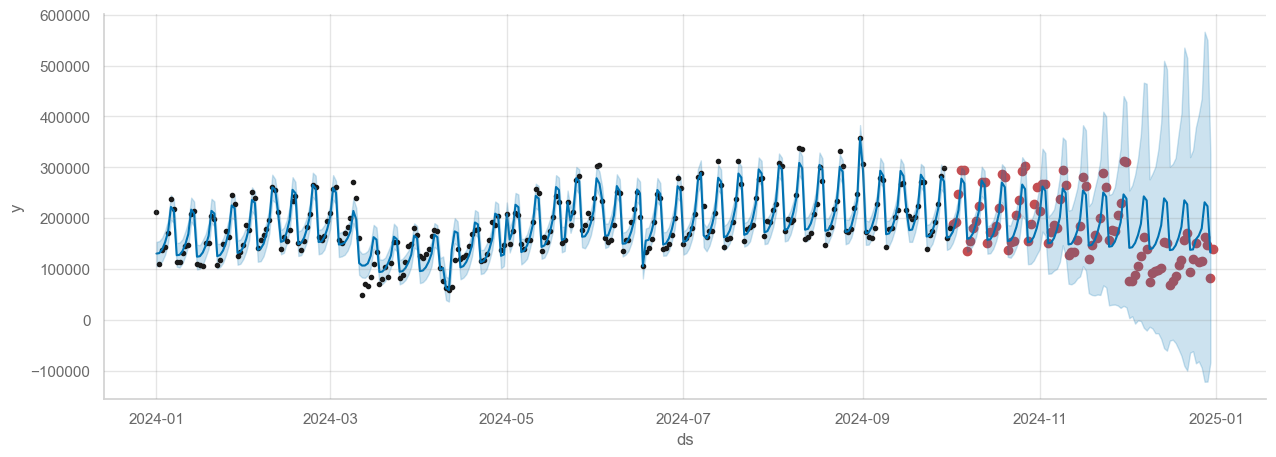

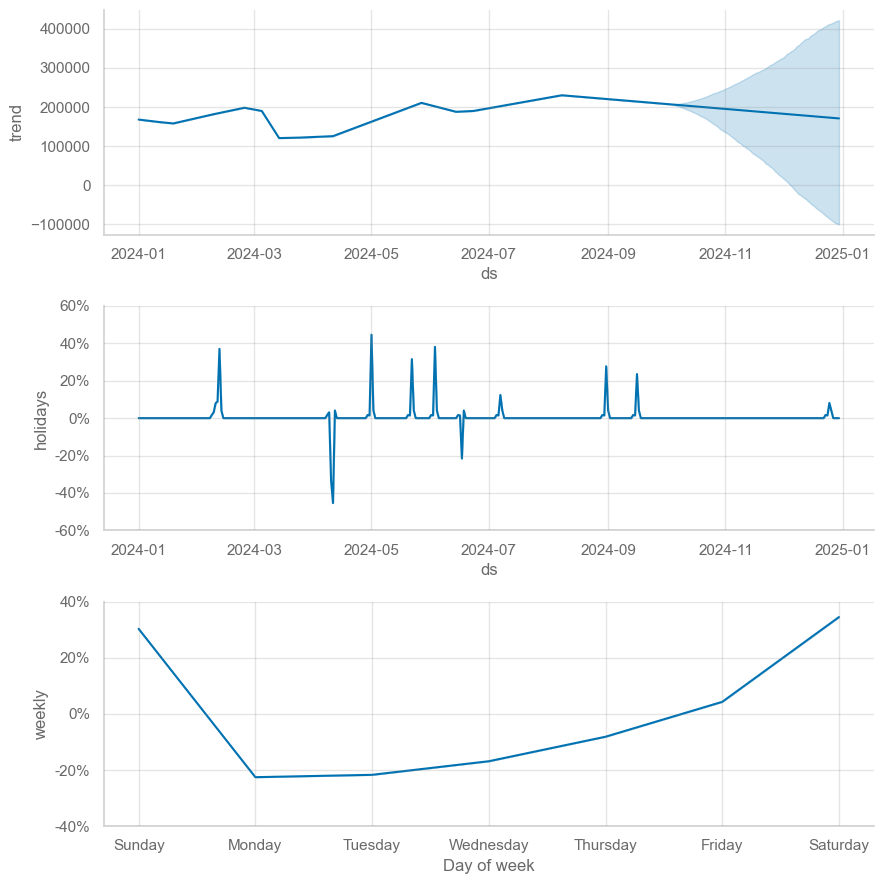

In [1550]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test_set.index, test_set['total_netsales'],color='r')
fig = m.plot(fcst_prophet_train, ax=ax)
fig2 = m.plot_components(fcst_prophet_train)

# Final 

In [1493]:
prediction_days = 90
forecast_start_date = max(aggregated_daily_sales_data.index)
forecast_start_date

Timestamp('2024-12-31 00:00:00')

21:42:26 - cmdstanpy - INFO - Chain [1] start processing
21:42:26 - cmdstanpy - INFO - Chain [1] done processing


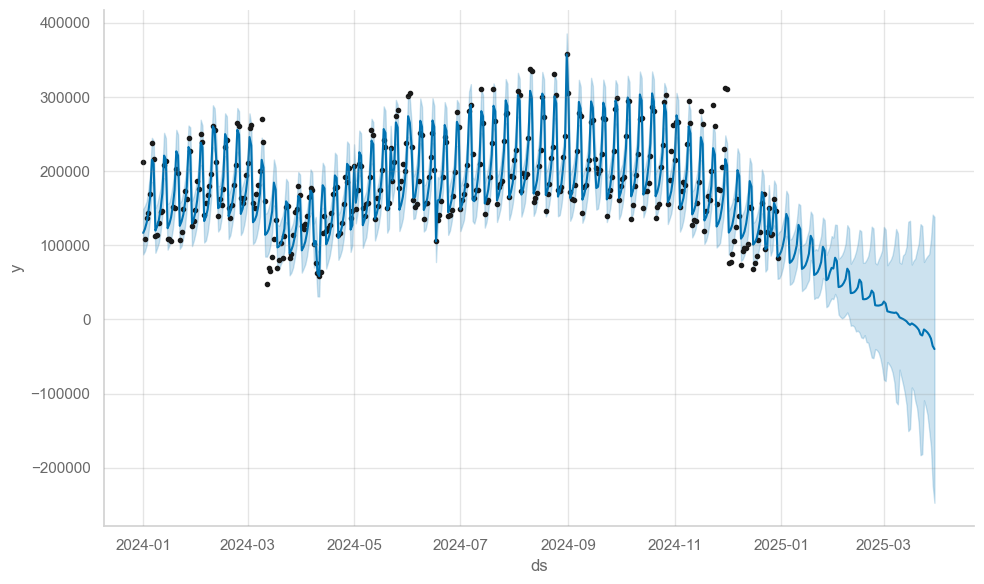

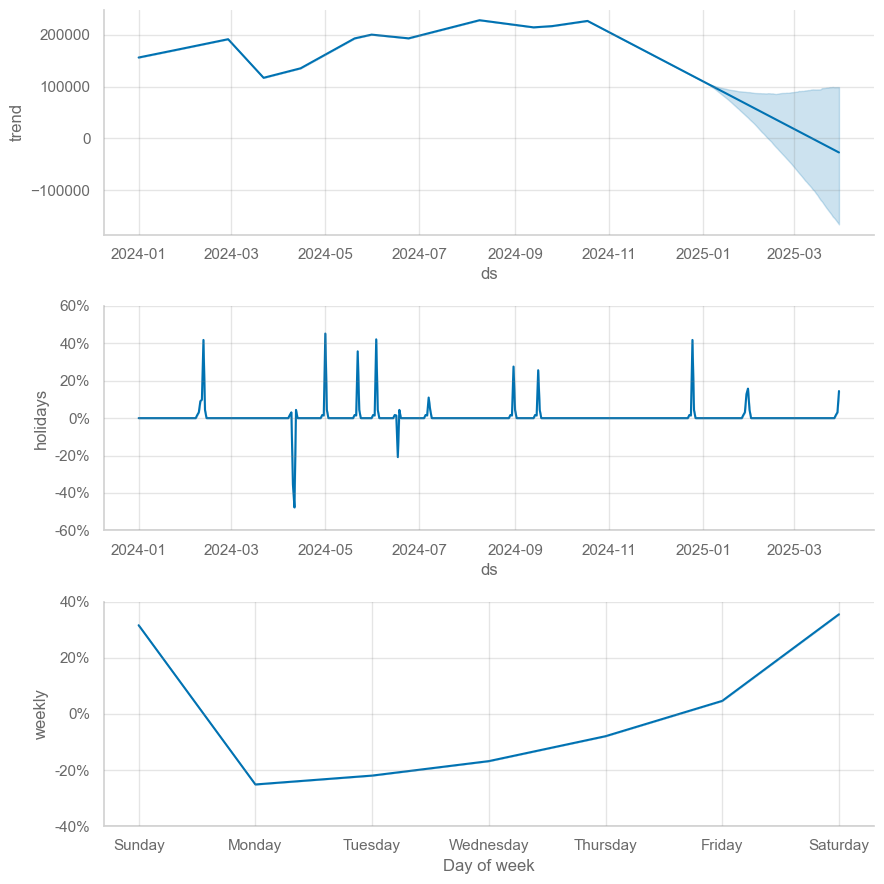

In [1498]:
df_copy = aggregated_daily_sales_data.copy().reset_index()
df_copy.columns = ['ds','y']
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]

#finding the right params_dict for this category
params_dictionary = dict(tuning_results.sort_values('mape').reset_index(drop=True).drop('mape',axis='columns').iloc[0])

#model
m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'],
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'],
            seasonality_mode = 'multiplicative',
            holidays_prior_scale = params_dictionary['holidays_prior_scale'],
            #changepoint_range = params_dictionary['changepoint_range'],
            holidays=holiday
           )
m.add_country_holidays(country_name='MY')

m.fit(df_copy_)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

fig1 = m.plot(fcst_prophet_train)
fig2 = m.plot_components(fcst_prophet_train)

In [1499]:
predicted_df = fcst_prophet_train[filter][['ds','yhat']]
predicted_df

,ds,yhat
365,2024-12-31,86896.81
366,2025-01-01,91336.35
367,2025-01-02,99649.43
368,2025-01-03,111637.10
369,2025-01-04,142430.87
370,2025-01-05,136280.52
371,2025-01-06,76379.14
372,2025-01-07,78385.27
373,2025-01-08,82262.99
374,2025-01-09,89607.74
